In [1]:
import gpmultipy, scipy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from gpmultipy import dataset
from gpmultipy.model import Model
from gpmultipy.prior import Prior
from gpmultipy.kernel import RBF, White
from gpmultipy.freeze import Freezer
from gpmultipy.sampler.slice import Slice
from gpmultipy.kernel import Product, Linear

In [3]:
%matplotlib inline

In [4]:
ds = dataset.DataSet('data/')
x,y,effect,labels = ds.build(Strain='ura3',mM_PQ=0.0,scale='range',Bio='E')
y = (y-y.mean())/y.std()

dm = np.ones((y.shape[1],1))

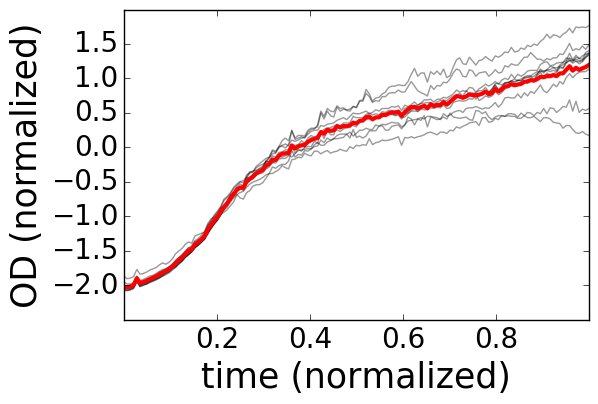

In [5]:
plt.plot(x,y,c='k',alpha=.4); plt.plot(x,y.mean(1),c='r',lw=3);
plt.xlabel("time (normalized)",fontsize=25)
plt.ylabel("OD (normalized)",fontsize=25)
plt.xticks(np.arange(.2,1,.2),fontsize=20)
plt.yticks(np.arange(-2,2,.5),fontsize=20)

plt.savefig("figures/data-singleReplicate.pdf",bbox_inches='tight',dpi=300)

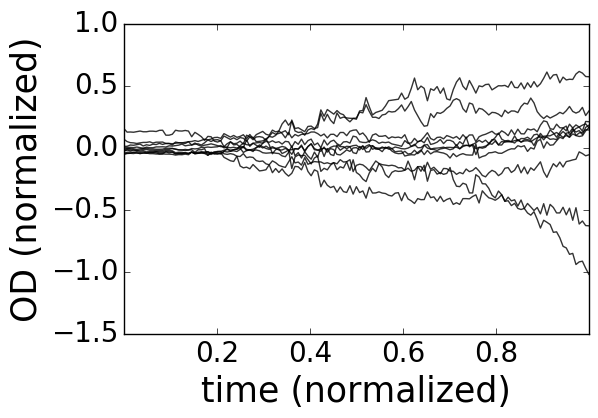

In [6]:
plt.figure(figsize=(6,4))

plt.plot(x,y-y.mean(1)[:,None],c='k',alpha=.8)

plt.xlabel("time (normalized)",fontsize=25)
plt.ylabel("OD (normalized)",fontsize=25)
plt.xticks(np.arange(.2,1,.2),fontsize=20)
plt.yticks(np.arange(-1.5,1.5,.5),fontsize=20)

plt.savefig("figures/residuals-singleReplicate.pdf",bbox_inches='tight')

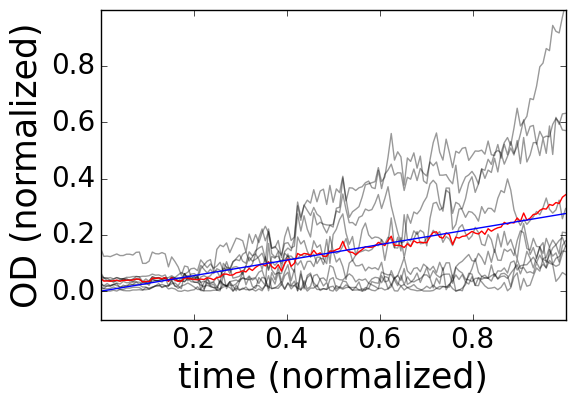

In [7]:
plt.figure(figsize=(6,4))

resid = y-y.mean(1)[:,None]
plt.plot(x,abs(resid),c='k',alpha=.4);
plt.plot(x,abs(resid).mean(1),c='r',alpha=1);

A = np.ones((x.shape[0],2))
A[:,1] = x[:,0]
beta,_,_,_ = np.linalg.lstsq(A,abs(resid).mean(1))
plt.plot(x,np.dot(A,beta))

plt.ylim(-.1,1)

plt.xlabel("time (normalized)",fontsize=25)
plt.ylabel("OD (normalized)",fontsize=25)
plt.xticks(np.arange(.2,1,.2),fontsize=20)
plt.yticks(np.arange(0,1,.2),fontsize=20)

plt.savefig("figures/residual-mean-singleReplicate.pdf",bbox_inches='tight')

# More data 

In [9]:
ds = dataset.DataSet('data/')
x,y,effect,labels = ds.build(Strain='ura3',mM_PQ=0.0,scale='range',effects=['Bio','Tech'])

neffect = effect.Bio.unique().shape[0]
for e in range(neffect):
    select = effect.values[:,0] == e
    y[:,select] -= y[0,select].mean()
    
y = (y-y.mean())/y.std()

In [10]:
select = effect.Tech != 9
y = y[:,np.where(select)[0]]
effect = effect.loc[select,:]

In [11]:
for b in [6,8,10,12]:
    select = (effect != np.array([[b,0]])).values.any(1)
    
    y = y[:,np.where(select)[0]]
    effect = effect.loc[select,:]

In [12]:
y.shape

(145, 98)

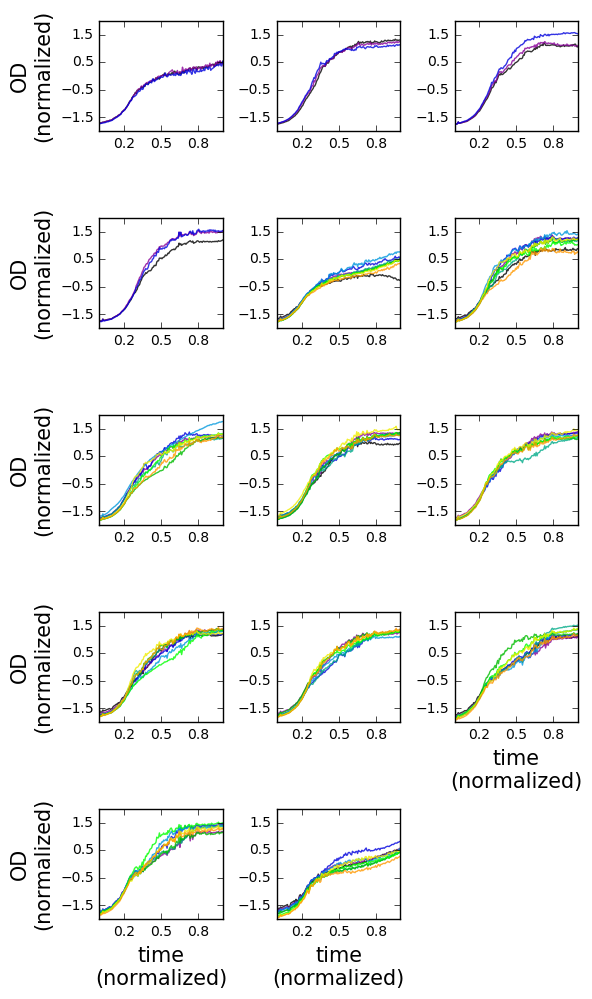

In [14]:
plt.figure(figsize=(6,10))

ncol = 3
cmap = plt.get_cmap('spectral')

for i in range(y.shape[1]):
    plt.subplot(neffect/ncol+1,ncol,effect.values[i,0]+1)
    #plt.plot(x,y[:,i],c=cmap(1.*effect.values[i,0]/neffect),alpha=.4);
    plt.plot(x,y[:,i],c=cmap(1.*effect.values[i,1]/10),alpha=.8,label=str(effect.values[i,1]));
    
    plt.ylim(-2,2)
    
for i in range(len(labels[0])):
    plt.subplot(neffect/ncol+1,ncol,i+1)
    #plt.title(labels[0][i])
    
    if i%ncol == 0:
        plt.yticks(np.arange(-1.5,2,1),fontsize=10)
        plt.ylabel("OD\n(normalized)",fontsize=15)
    else:
        plt.yticks(np.arange(-1.5,2,1),fontsize=10)
        
    if i >= 11:
        plt.xticks(np.arange(.2,1,.3),fontsize=10)
        plt.xlabel("time\n(normalized)",fontsize=15)
    else:
        plt.xticks(np.arange(.2,1,.3),fontsize=10)
    
plt.tight_layout()

plt.savefig("figures/data-multipleReplicates.pdf",bbox_inches='tight',dpi=300)

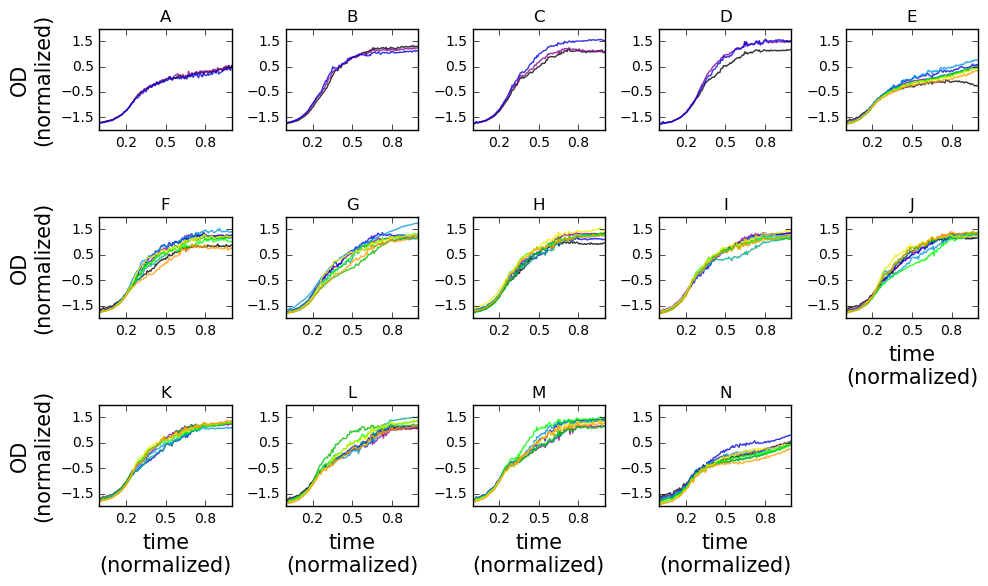

In [23]:
plt.figure(figsize=(10,6))

ncol = 5

for i in range(y.shape[1]):
    plt.subplot(neffect/ncol+1,ncol,effect.values[i,0]+1)
    #plt.plot(x,y[:,i],c=cmap(1.*effect.values[i,0]/neffect),alpha=.4);
    plt.plot(x,y[:,i],c=cmap(1.*effect.values[i,1]/10),alpha=.8,label=str(effect.values[i,1]));
    
    plt.ylim(-2,2)
    
for i in range(len(labels[0])):
    plt.subplot(neffect/ncol+1,ncol,i+1)
    plt.title(labels[0][i])
    
    if i%ncol == 0:
        plt.yticks(np.arange(-1.5,2,1),fontsize=10)
        plt.ylabel("OD\n(normalized)",fontsize=15)
    else:
        plt.yticks(np.arange(-1.5,2,1),fontsize=10)
        
    if i >= 9:
        plt.xticks(np.arange(.2,1,.3),fontsize=10)
        plt.xlabel("time\n(normalized)",fontsize=15)
    else:
        plt.xticks(np.arange(.2,1,.3),fontsize=10)
    
plt.tight_layout()

plt.savefig("figures/data-multipleReplicates-alt.pdf",bbox_inches='tight',dpi=300)

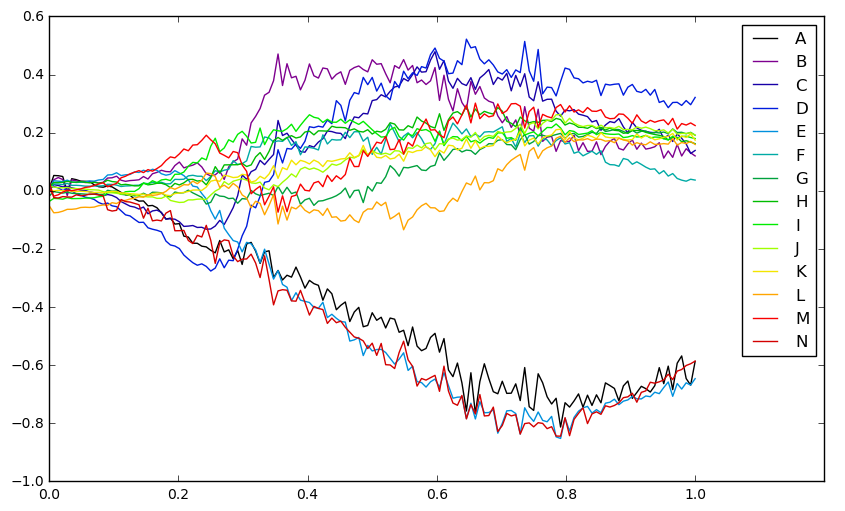

In [27]:
mu = y.mean(1)

plt.figure(figsize=(10,6))

for i,e in enumerate(effect.Bio.unique()):
    
    select = effect.Bio.values == e
    yselect = y[:,select]
    
    plt.plot(x,yselect.mean(1)-mu,c=cmap(1.*i/effect.Bio.unique().shape[0]),label=labels[0][e])
    
plt.xlim(x.min(),x.max()*1.2)
plt.legend()

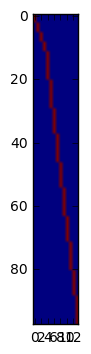

In [174]:
bioMatrix = np.zeros((y.shape[1],effect.Bio.unique().shape[0]))
for i,e in enumerate(effect.Bio):
#     print i,e
    bioMatrix[i,e] = 1
    
plt.imshow(bioMatrix)

In [175]:
dm_randomEffect = np.column_stack((np.ones(y.shape[1]),
                                   bioMatrix,
                                   np.eye(y.shape[1])))

In [409]:
m_randomEffect_bio = gpfanova.base.Base(x,y,designMatrix=dm_randomEffect,
                                        priorGroups=[[0],range(1,bioMatrix.shape[1]+1),range(bioMatrix.shape[1]+1,dm_randomEffect.shape[1])],
                                        bounds={'prior0_lengthscale':(-1,2),
                                                'prior1_lengthscale':(-1,2),
                                                'prior2_lengthscale':(-1,2),
                                                'prior1_sigma':(-4,-1),
                                                'prior2_sigma':(-4,-1),})

m_randomEffect_bio.parameter_cache.prior1_sigma = -2
m_randomEffect_bio.parameter_cache.prior2_sigma = -2

ERROR:gpfanova.base:design matrix is of rank 112, but there are 127 functions!


In [411]:
m_randomEffect_bio.sample(50,thin=10)

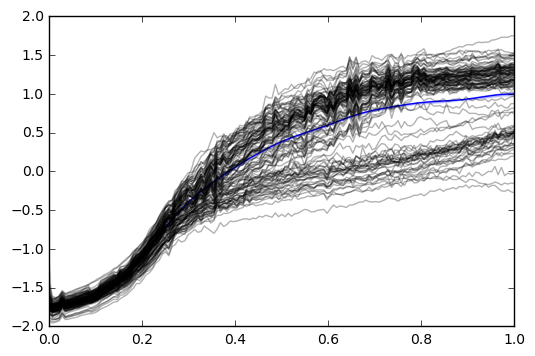

In [412]:
gpfanova.plot.plotFunctionSamples(m_randomEffect_bio.functionSamples(0).values,x=x[:,0])
plt.plot(x[:,0],y,c='k',alpha=.3);

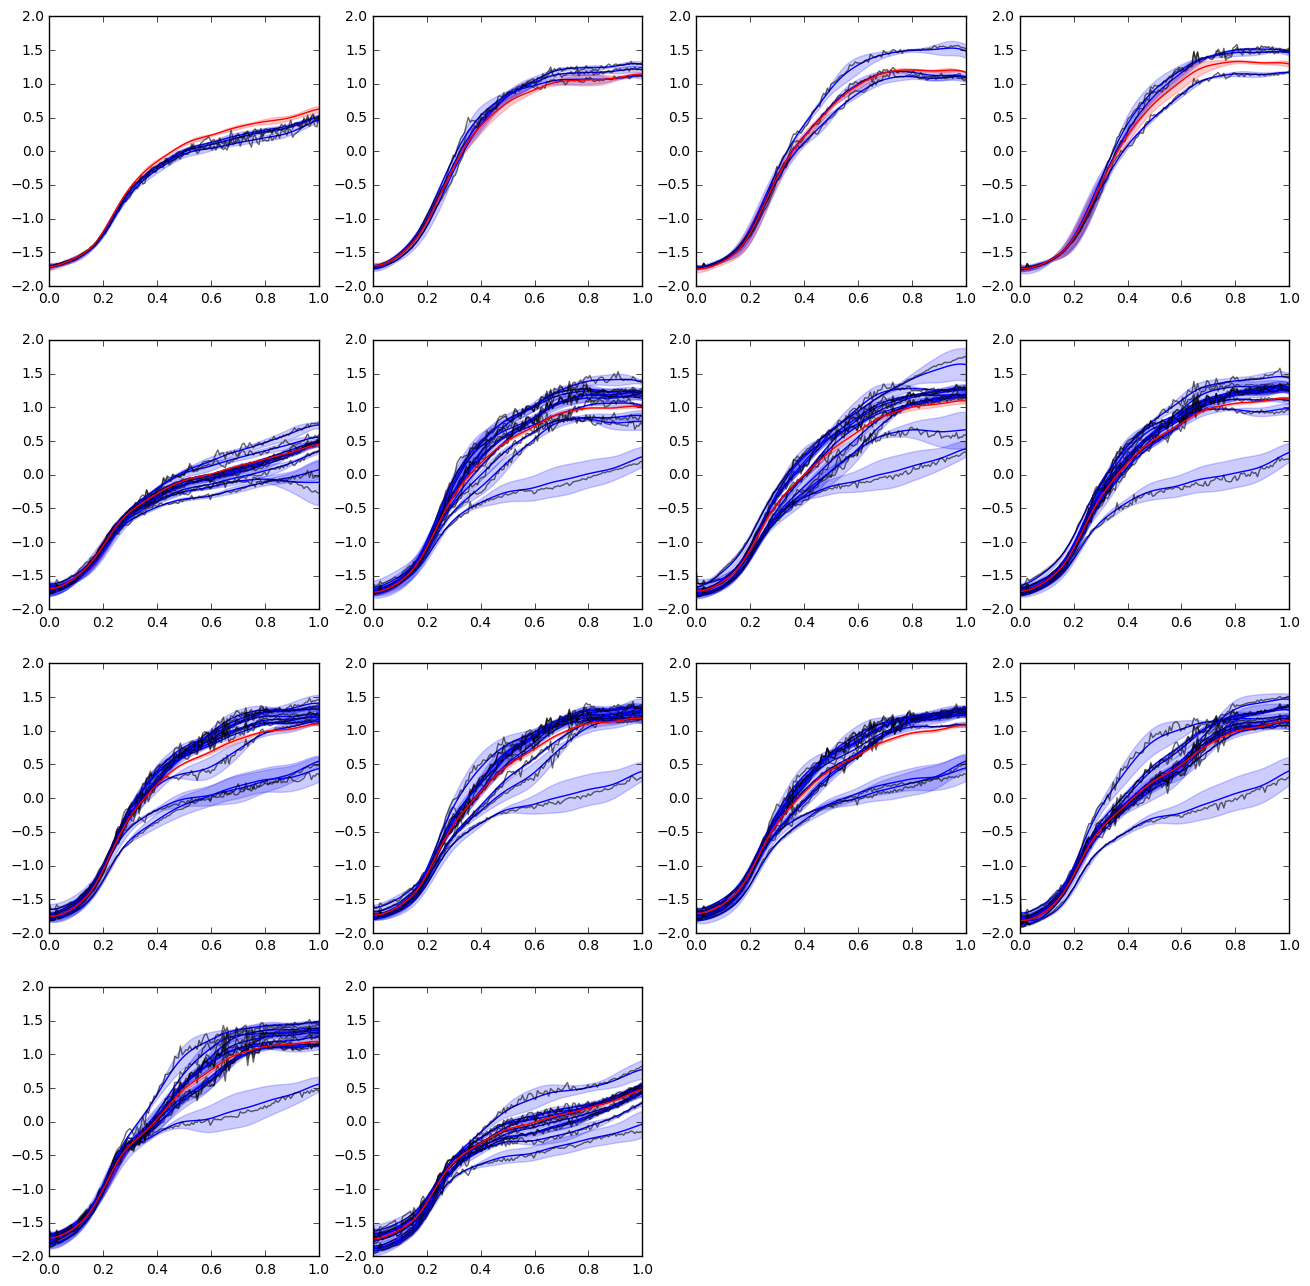

In [413]:
plt.figure(figsize=(16,16))


tensor = np.array([m_randomEffect_bio.functionSamples(i).values.T for i in range(m_randomEffect_bio.f)])

for r in range(y.shape[1]):
    plt.subplot(neffect/4+1,4,effect.values[r,0]+1)
    samp = np.dot(tensor.T,m_randomEffect_bio.design_matrix[r,:])
    gpfanova.plot.plotFunctionSamples(samp,x=x[:,0])
    
    plt.plot(x[:,0],y[:,r],c='k',alpha=.6);
    
for e in range(neffect):
    plt.subplot(neffect/4+1,4,e+1)
    samp = m_randomEffect_bio.functionSamples(0).values + m_randomEffect_bio.functionSamples(e+1).values
    gpfanova.plot.plotFunctionSamples(samp,x=x[:,0],c='r')
    
    plt.ylim(-2,2)

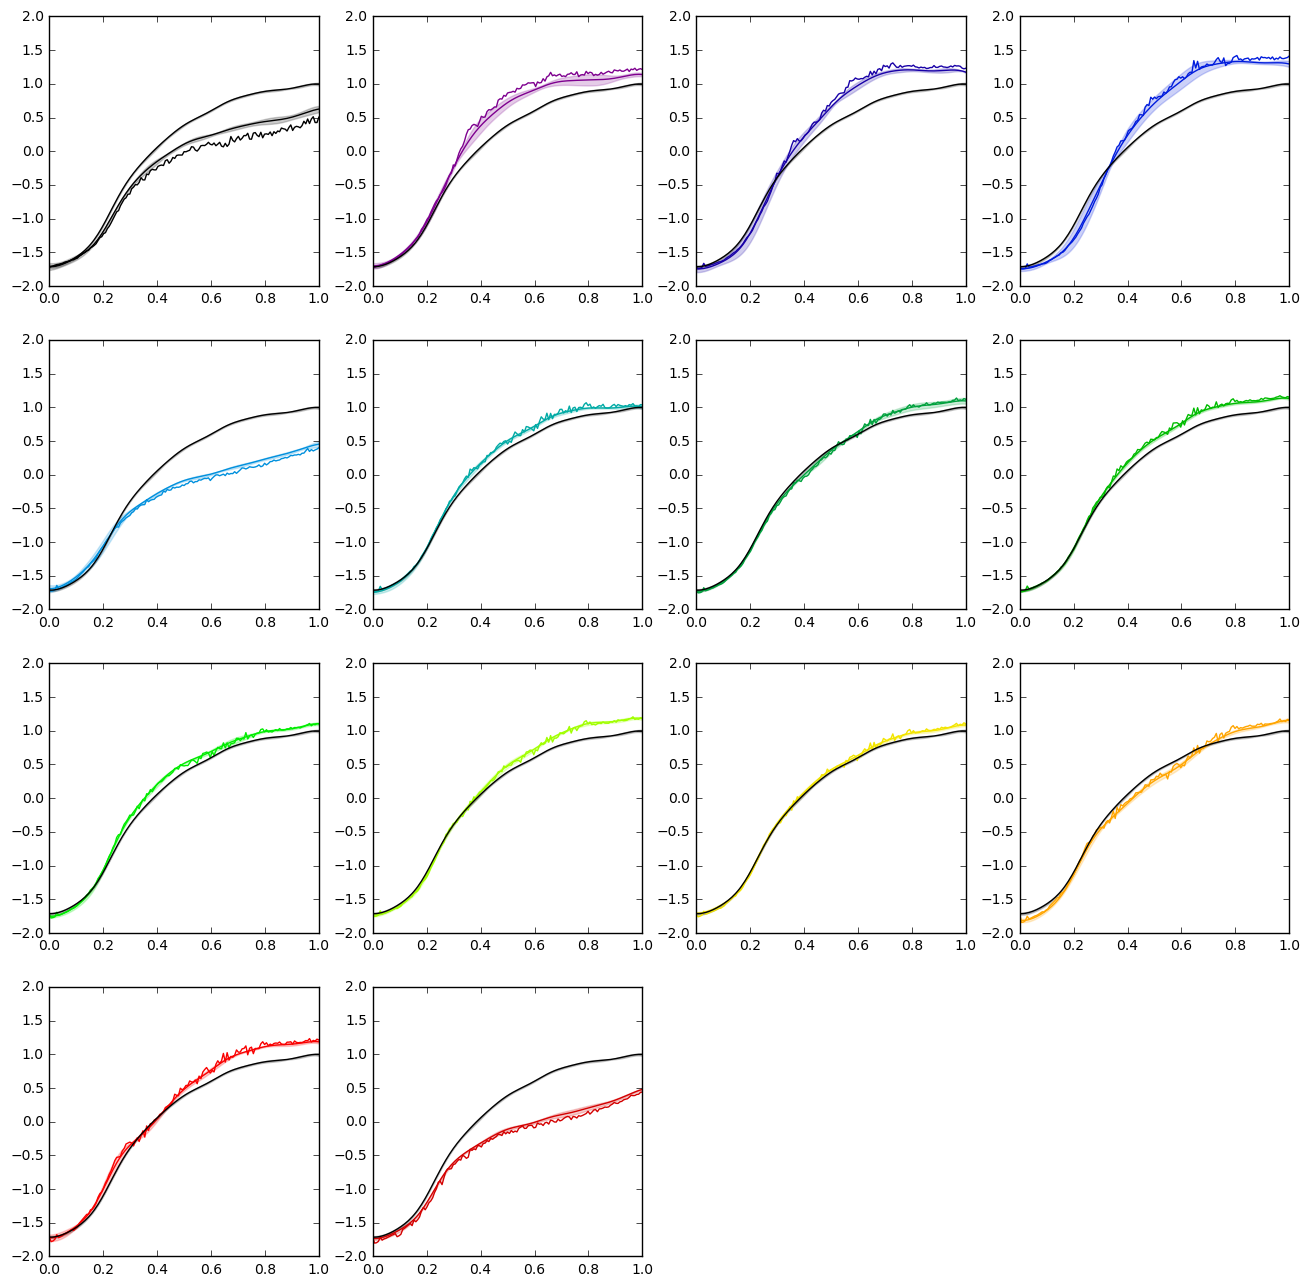

In [414]:
plt.figure(figsize=(16,16))

for e in range(neffect):
    plt.subplot(neffect/4+1,4,e+1)
    samp = m_randomEffect_bio.functionSamples(0).values + m_randomEffect_bio.functionSamples(e+1).values
    gpfanova.plot.plotFunctionSamples(samp,x=x[:,0],c=cmap(1.*e/neffect))
    plt.plot(x[:,0],y[:,effect.values[:,0]==e].mean(1),c=cmap(1.*e/neffect))
    
    gpfanova.plot.plotFunctionSamples(m_randomEffect_bio.functionSamples(0).values,x=x[:,0],c='k')
    
    plt.ylim(-2,2)

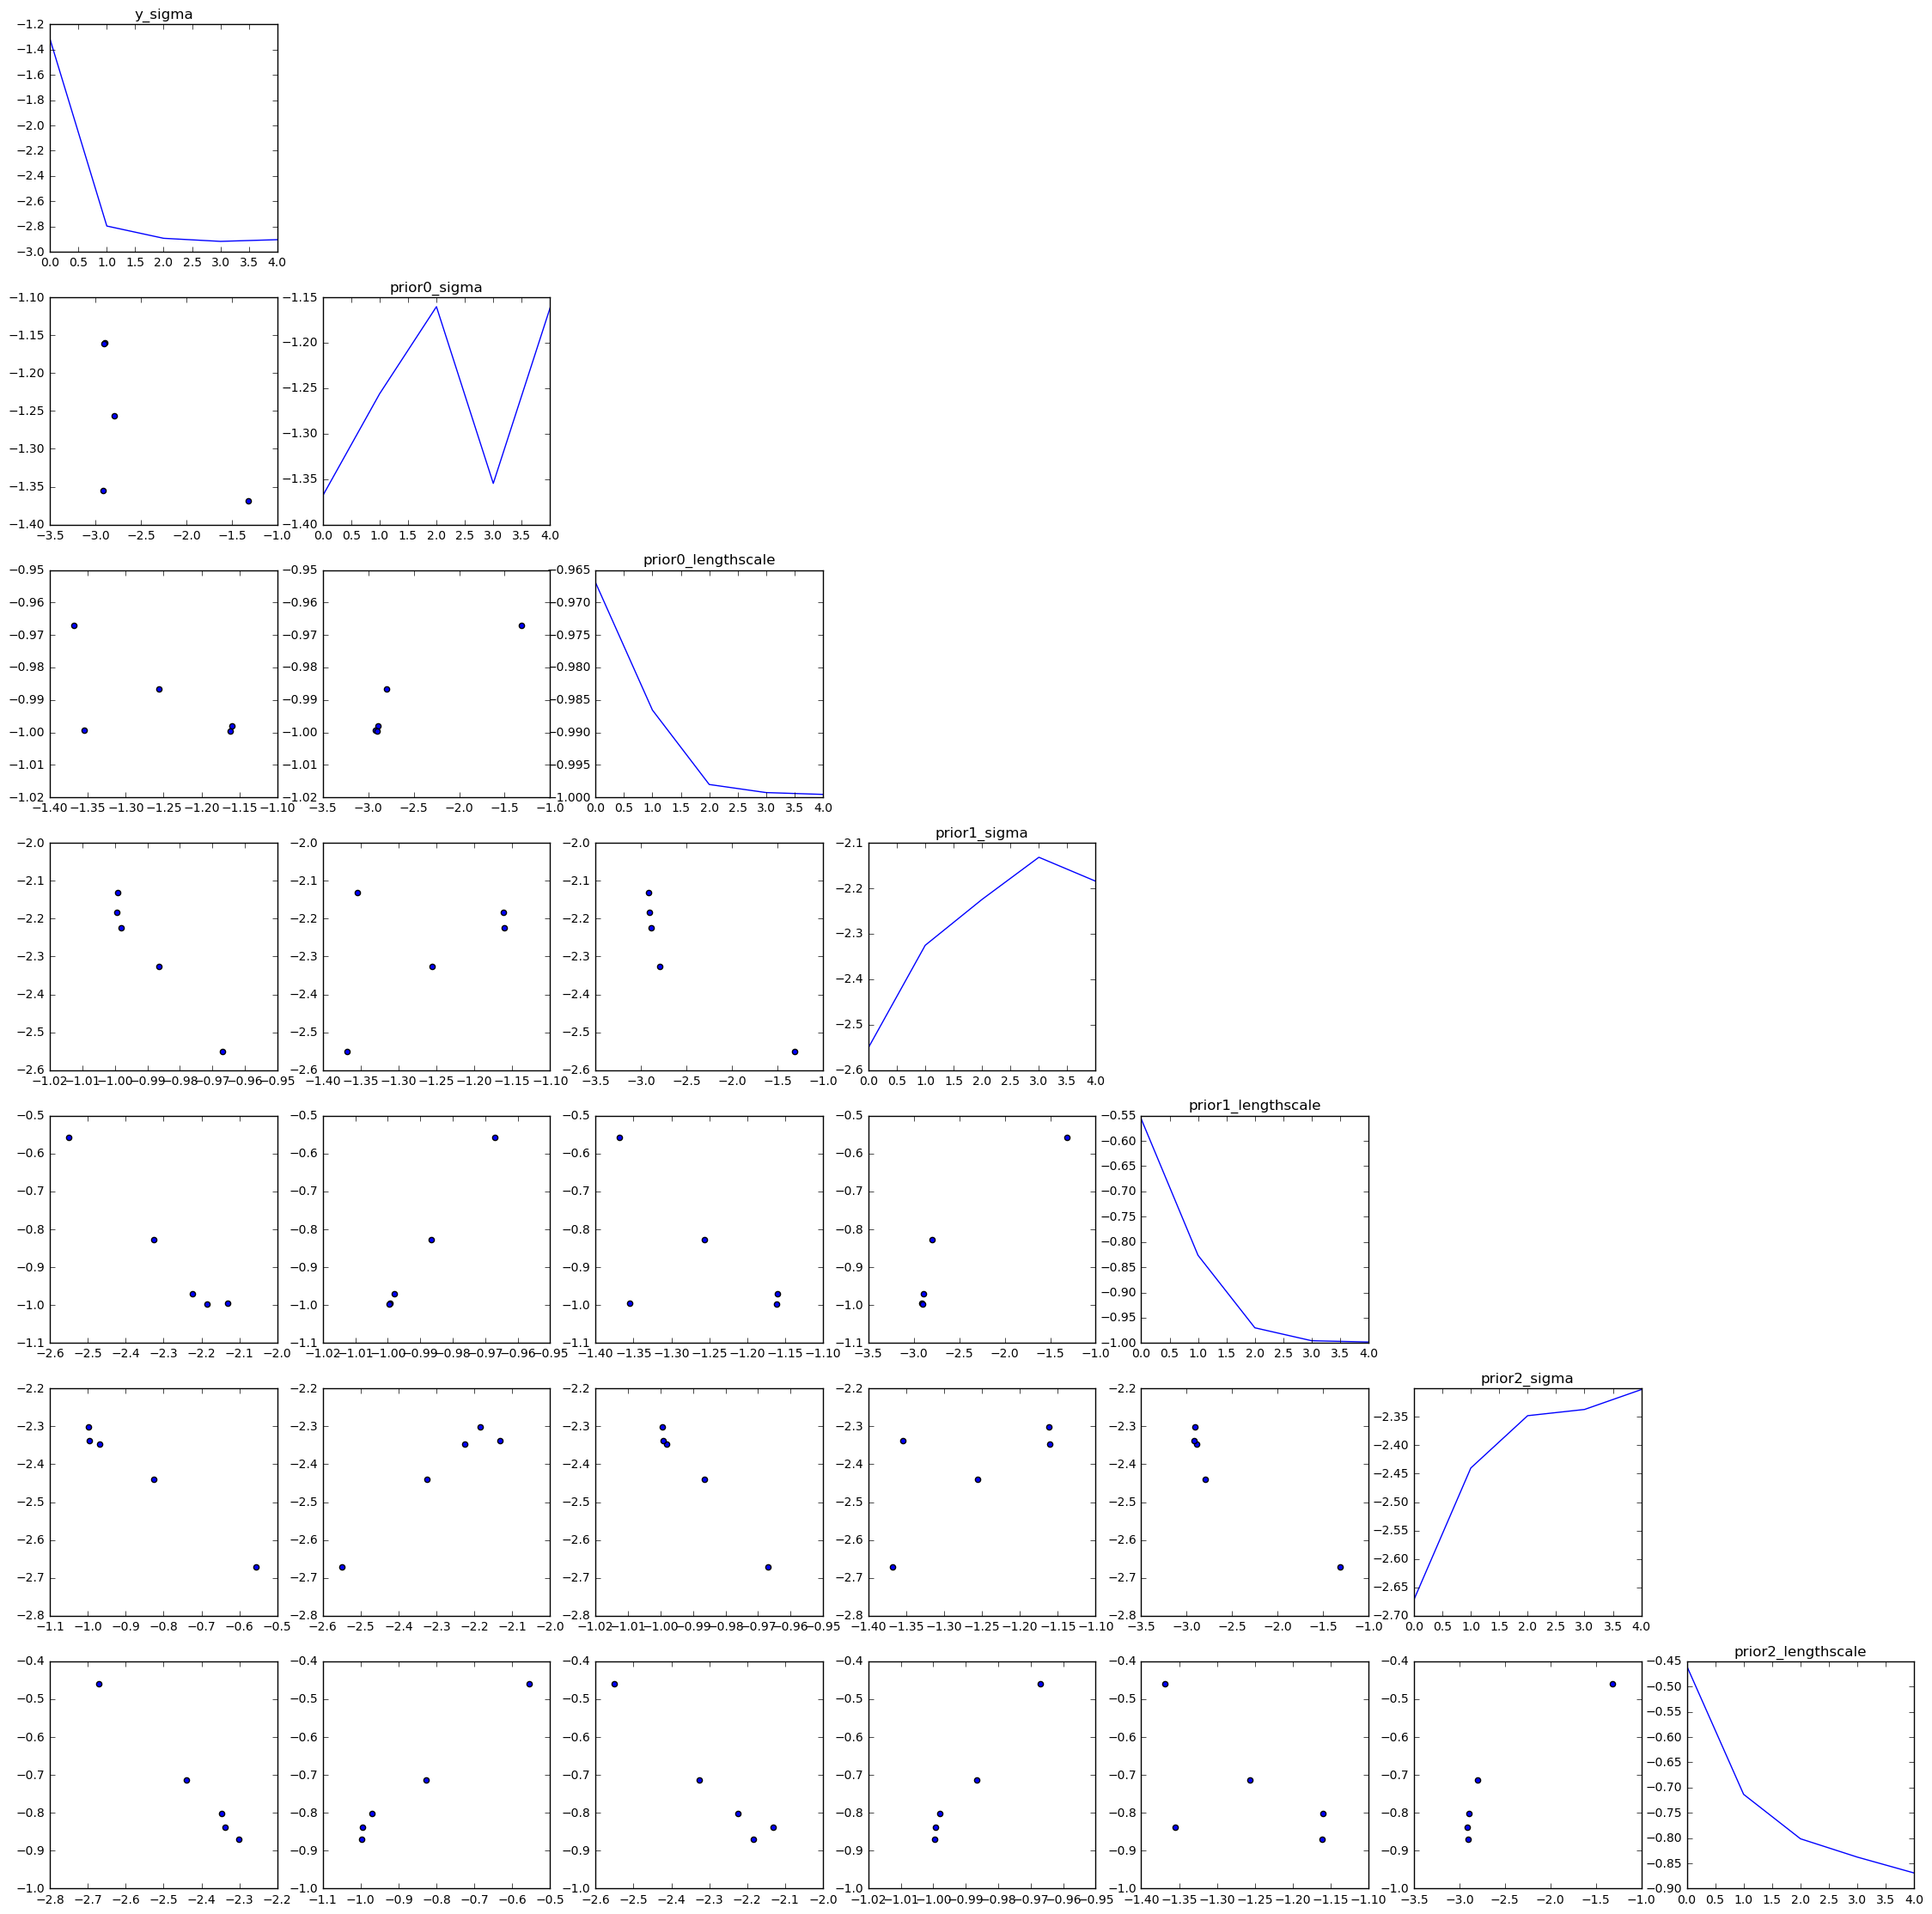

In [415]:
params = ['y_sigma','prior0_sigma','prior0_lengthscale','prior1_sigma','prior1_lengthscale','prior2_sigma','prior2_lengthscale']

plt.figure(figsize=(len(params)*4,len(params)*4))
for i,p in enumerate(params):
    plt.subplot(len(params),len(params),i+1+i*len(params))
    plt.title(p)
    plt.plot(m_randomEffect_bio.parameter_history[p])
    
    for j,p2 in enumerate(params[:i]):
        plt.subplot(len(params),len(params),i+1+i*len(params)-j-1)
        plt.scatter(m_randomEffect_bio.parameter_history[p2],m_randomEffect_bio.parameter_history[p])

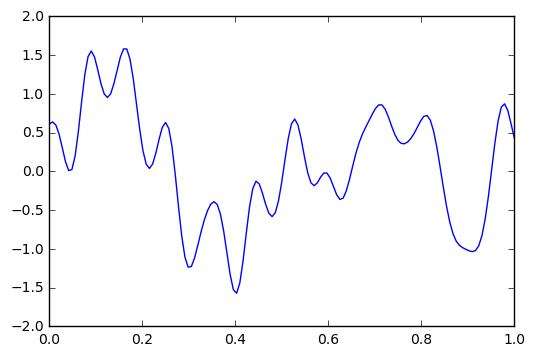

In [639]:
cov = m_randomEffect_bio.kernels[2].K(m_randomEffect.x,prior2_lengthscale=-1.5,prior2_sigma=0)

fsample = scipy.stats.multivariate_normal.rvs(np.zeros(m_randomEffect_bio.x.shape[0]),cov)

plt.plot(x[:,0],fsample)

In [538]:
m_randomEffect_bio.functionSamples(0).values.std(0).mean(),\
m_randomEffect.functionSamples(0).values.std(0).mean(),\
m_noReplicate.functionSamples(0).values.std(0).mean(),\
m_replicateEffect.functionSamples(0).values.std(0).mean()

(0.0048283119322066097,
 0.036129691679215904,
 0.019364231032352568,
 0.0035765078315592464)

## Integrate replicates 

In [516]:
reload(gpfanova.base)

<module 'gpfanova.base' from '/home/ptonner/dev/combinatorial-growth/local/lib/python2.7/site-packages/gpfanova/base.pyc'>

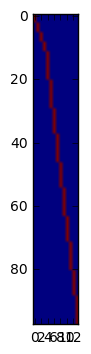

In [176]:
bioMatrix = np.zeros((y.shape[1],effect.Bio.unique().shape[0]))
for i,e in enumerate(effect.Bio):
#     print i,e
    bioMatrix[i,e] = 1
    
plt.imshow(bioMatrix)

In [177]:
dm_randomEffect_intRep = np.column_stack((np.ones(y.shape[1]),
                                   bioMatrix,))

m_randomEffect_bio_intRep = gpfanova.base.Base_withReplicate(x,y,designMatrix=dm_randomEffect_intRep,
                                        priorGroups=[[0],range(1,bioMatrix.shape[1]+1)],
                                        bounds={'y_sigma':(-4,-1),
                                                'prior0_lengthscale':(-1,2),
                                                'prior1_lengthscale':(-1,2),
                                                'prior0_sigma':(-4,-1),
                                                'prior1_sigma':(-4,-1),
                                                },
                                        replicateSigmaBounds=(-4,-1),
                                        replicateLengthscaleBounds=(-1,2))

# m_randomEffect_bio_intRep = gpfanova.base.Base(x,y,designMatrix=dm_randomEffect_intRep,
#                                         priorGroups=[[0],range(1,bioMatrix.shape[1]+1)],
#                                         bounds={'prior0_lengthscale':(-1,2),
#                                                 'prior1_lengthscale':(-1,2),
#                                                 'prior1_sigma':(-4,-1),
#                                                 'y_sigma':(-4,-1)},
#                                         replicateSigmaBounds=(-4,-1),
#                                         replicateLengthscaleBounds=(-1,2))

m_randomEffect_bio_intRep.parameter_cache.prior0_sigma

ERROR:gpfanova.base:design matrix is of rank 14, but there are 15 functions!


-2.5

In [183]:
m_randomEffect_bio_intRep.sample(500,thin=10)

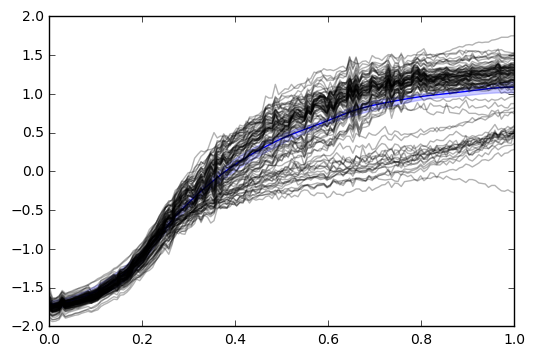

In [179]:
gpfanova.plot.plotFunctionSamples(m_randomEffect_bio_intRep.functionSamples(0).values,x=x[:,0])
plt.plot(x[:,0],y,c='k',alpha=.3);

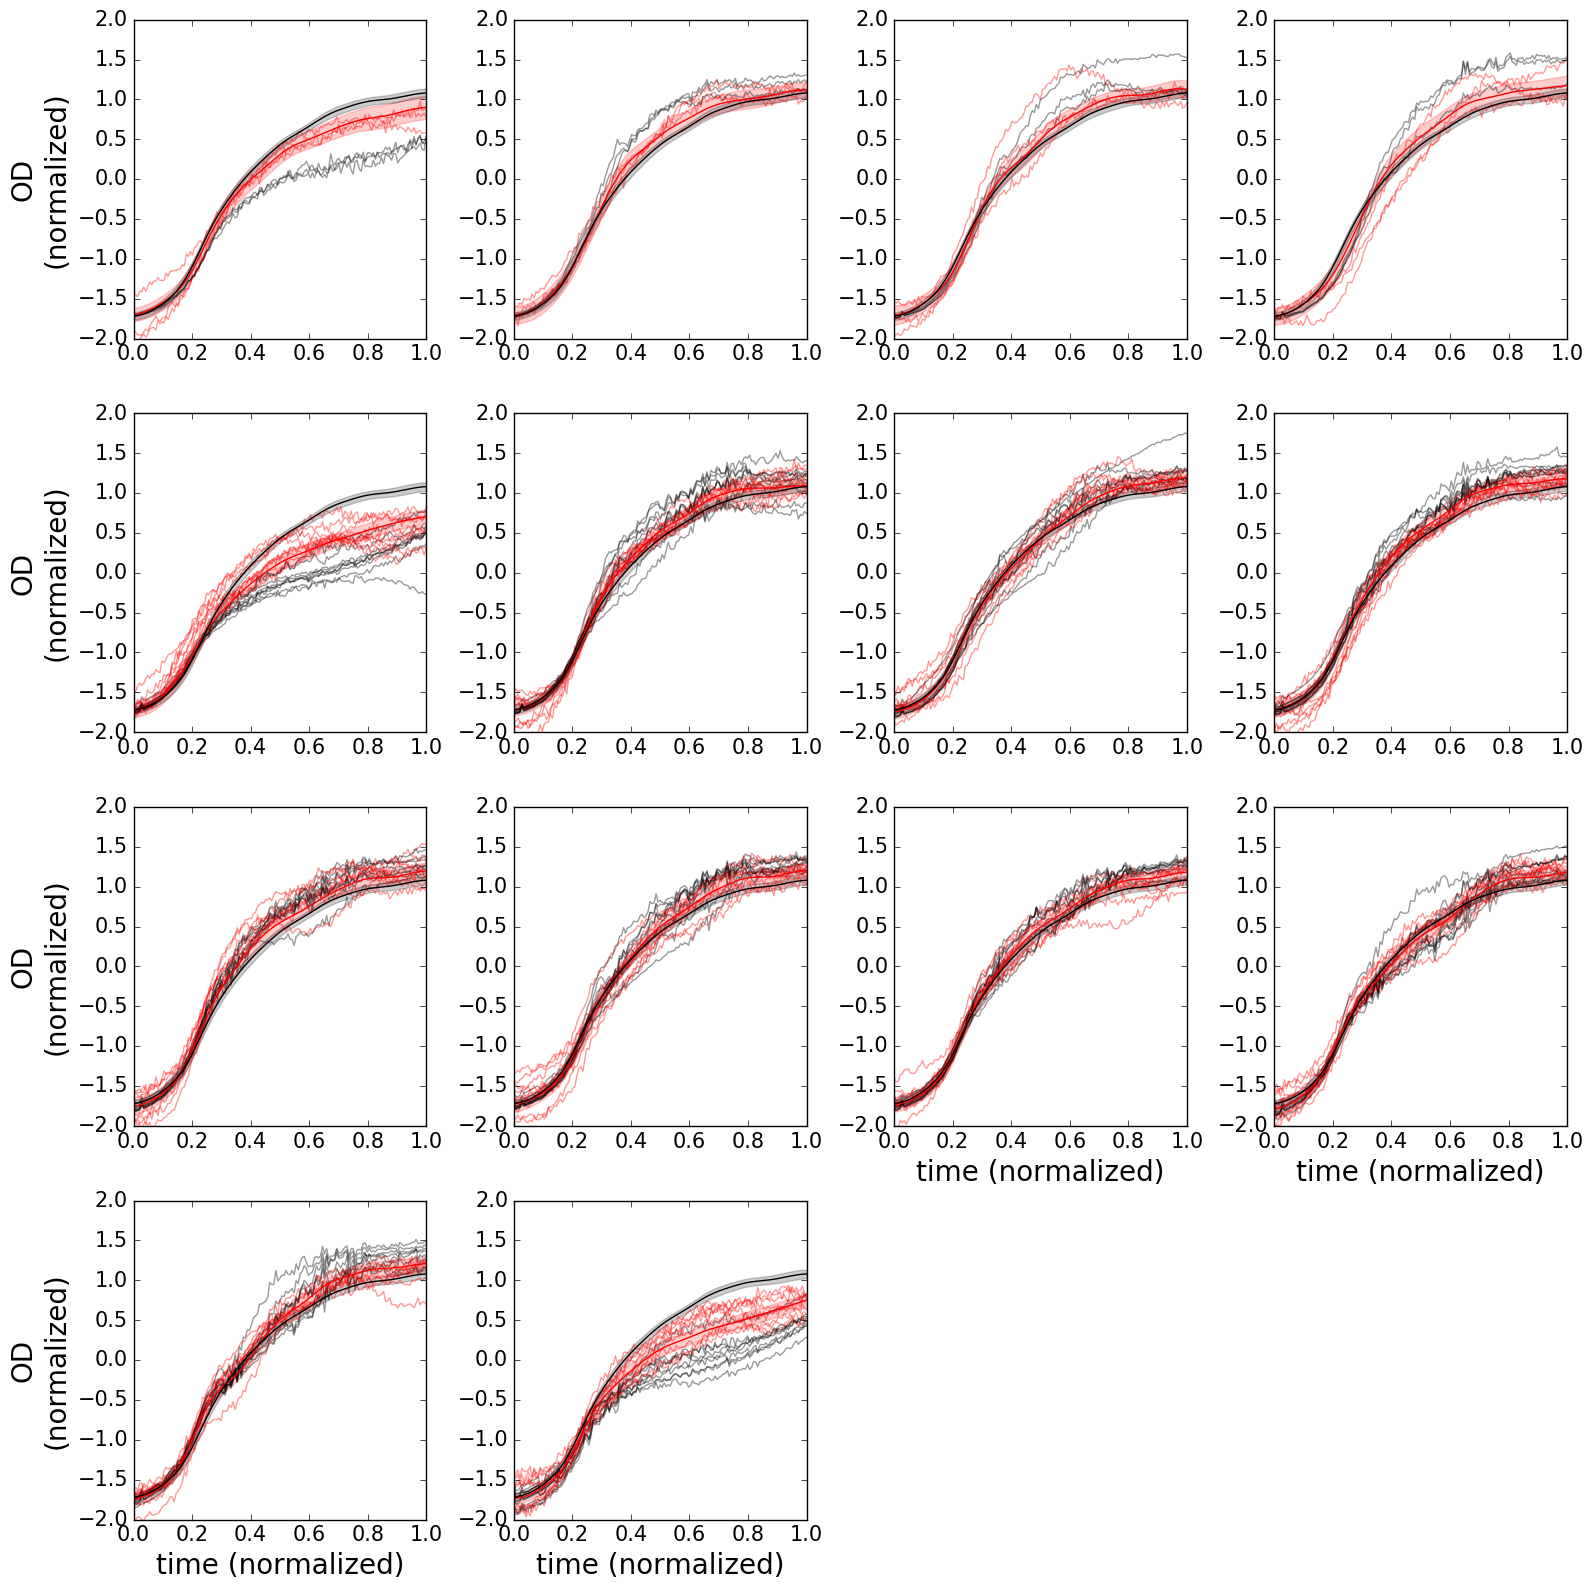

In [266]:
plt.figure(figsize=(16,16))

tensor = np.array([m_randomEffect_bio_intRep.functionSamples(i).values.T for i in range(m_randomEffect_bio_intRep.f)])

for r in range(y.shape[1]):
    plt.subplot(neffect/4+1,4,effect.values[r,0]+1)
    samp = np.dot(tensor.T,m_randomEffect_bio_intRep.design_matrix[r,:])
    
    #gpfanova.plot.plotFunctionSamples(samp,x=x[:,0])
    
    samp = np.dot(tensor.T,m_randomEffect_bio_intRep.design_matrix[r,:])
    samp = samp[-1,:]
    cov = m_randomEffect_bio_intRep.y_k.K(x)

    sample = scipy.stats.multivariate_normal.rvs(samp,cov)

    plt.plot(x[:,0],sample,c='r',alpha=.4)
    
    plt.plot(x[:,0],y[:,r],c='k',alpha=.4);
    
for e in range(neffect):
    plt.subplot(neffect/4+1,4,e+1)
    samp = m_randomEffect_bio_intRep.functionSamples(0).values + m_randomEffect_bio_intRep.functionSamples(e+1).values
    gpfanova.plot.plotFunctionSamples(samp,x=x[:,0],c='r')
    
    gpfanova.plot.plotFunctionSamples(m_randomEffect_bio_intRep.functionSamples(0).values,x=x[:,0],c='k')
    
    if e >= 10:
        plt.xlabel("time (normalized)",fontsize=20)
        
    if e%4 == 0:
        plt.ylabel("OD\n(normalized)",fontsize=20)
        
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    
    
    plt.ylim(-2,2)
    
plt.tight_layout()

plt.savefig("figures/ura3-pq-replicate/model-multipleReplicates-generative.pdf",bbox_inches='tight',dpi=300)

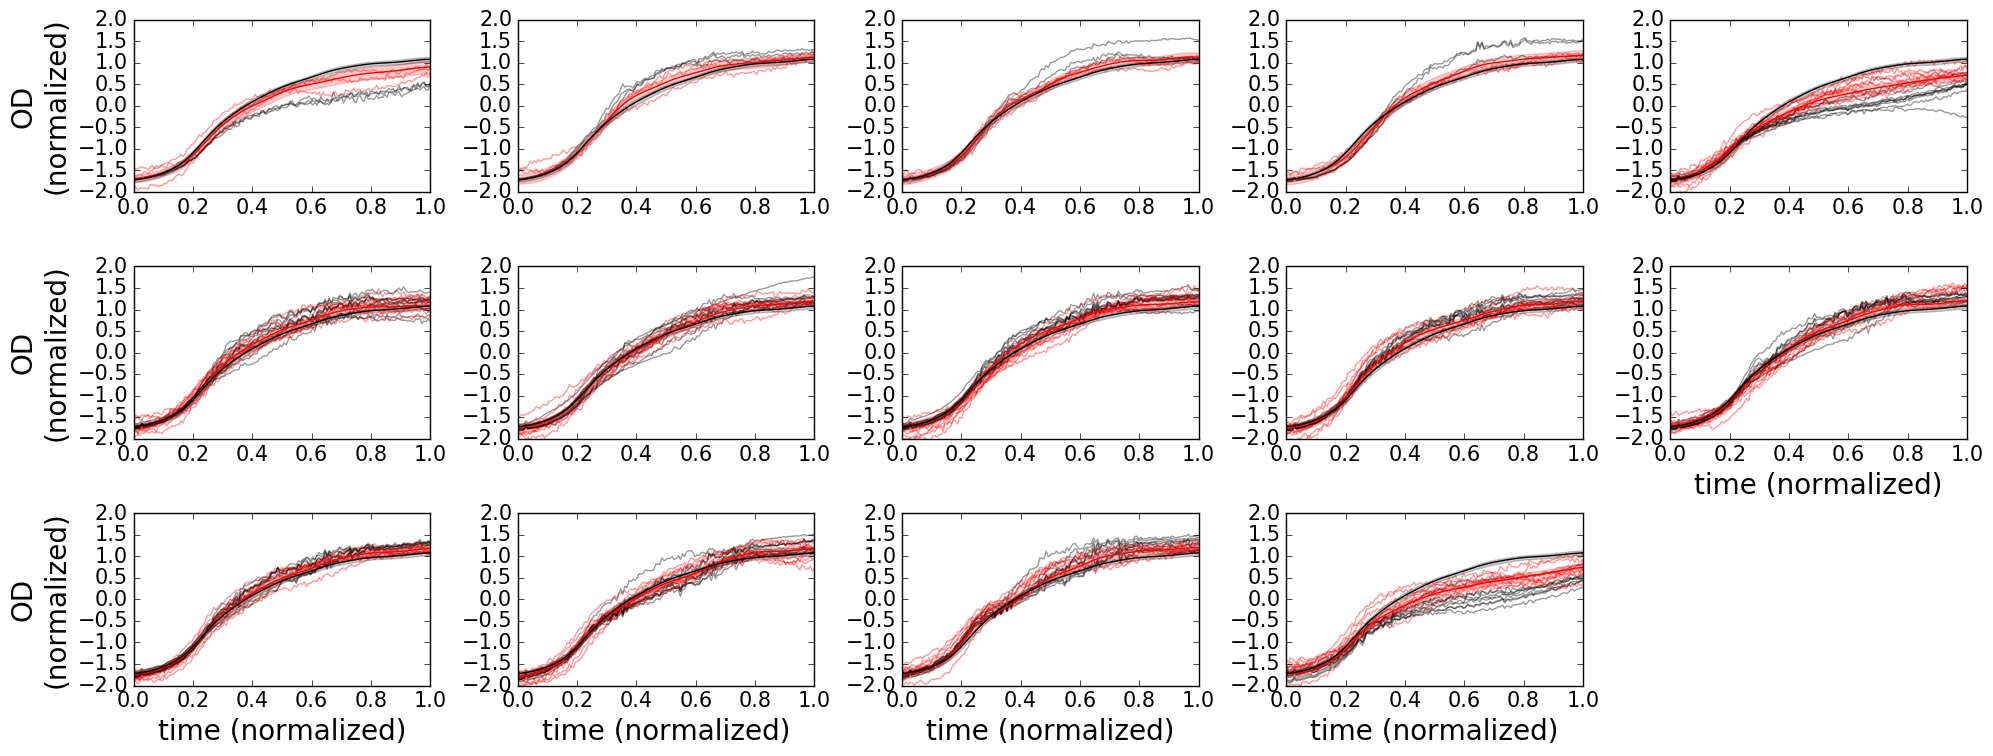

In [271]:
plt.figure(figsize=(20,12))

tensor = np.array([m_randomEffect_bio_intRep.functionSamples(i).values.T for i in range(m_randomEffect_bio_intRep.f)])

for r in range(y.shape[1]):
    plt.subplot(neffect/3+1,5,effect.values[r,0]+1)
    samp = np.dot(tensor.T,m_randomEffect_bio_intRep.design_matrix[r,:])
    
    #gpfanova.plot.plotFunctionSamples(samp,x=x[:,0])
    
    samp = np.dot(tensor.T,m_randomEffect_bio_intRep.design_matrix[r,:])
    samp = samp[-1,:]
    cov = m_randomEffect_bio_intRep.y_k.K(x)

    sample = scipy.stats.multivariate_normal.rvs(samp,cov)

    plt.plot(x[:,0],sample,c='r',alpha=.4)
    
    plt.plot(x[:,0],y[:,r],c='k',alpha=.4);
    
for e in range(neffect):
    plt.subplot(neffect/3+1,5,e+1)
    samp = m_randomEffect_bio_intRep.functionSamples(0).values + m_randomEffect_bio_intRep.functionSamples(e+1).values
    gpfanova.plot.plotFunctionSamples(samp,x=x[:,0],c='r')
    
    gpfanova.plot.plotFunctionSamples(m_randomEffect_bio_intRep.functionSamples(0).values,x=x[:,0],c='k')
    
    if e >= 9:
        plt.xlabel("time (normalized)",fontsize=20)
        
    if e%5 == 0:
        plt.ylabel("OD\n(normalized)",fontsize=20)
        
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    
    
    plt.ylim(-2,2)
    
plt.tight_layout()

plt.savefig("figures/ura3-pq-replicate/model-multipleReplicates-generative-alt.pdf",bbox_inches='tight',dpi=300)

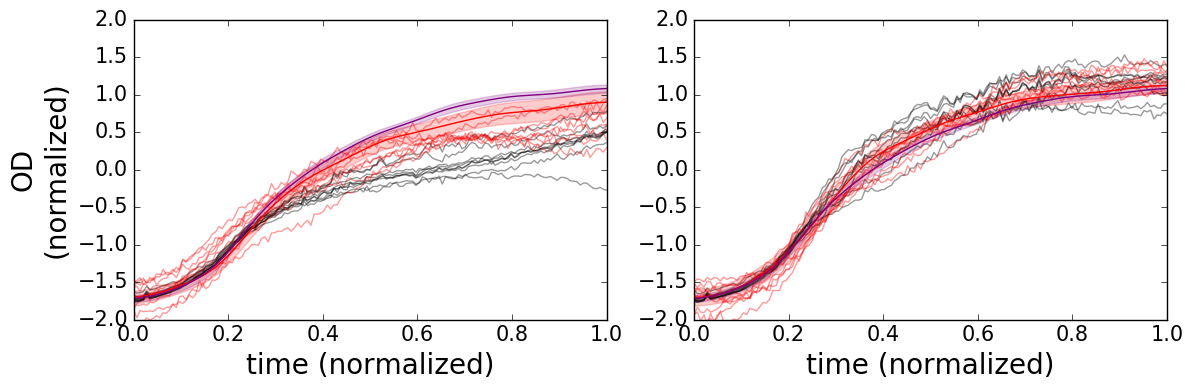

In [208]:
plt.figure(figsize=(12,4))

tensor = np.array([m_randomEffect_bio_intRep.functionSamples(i).values.T for i in range(m_randomEffect_bio_intRep.f)])

effectSelect = [4,5]

for r in range(y.shape[1]):
    if not effect.values[r,0] in effectSelect:
        continue
    
    plt.subplot(1,2,effectSelect.index(effect.values[r,0])+1)
    samp = np.dot(tensor.T,m_randomEffect_bio_intRep.design_matrix[r,:])
    
    #gpfanova.plot.plotFunctionSamples(samp,x=x[:,0])
    
    samp = np.dot(tensor.T,m_randomEffect_bio_intRep.design_matrix[r,:])
    samp = samp[-1,:]
    cov = m_randomEffect_bio_intRep.y_k.K(x)

    sample = scipy.stats.multivariate_normal.rvs(samp,cov)

    plt.plot(x[:,0],sample,c='r',alpha=.4)
    
    plt.plot(x[:,0],y[:,r],c='k',alpha=.4);
    
for e in range(len(effectSelect)):
    plt.subplot(1,2,e+1)
    samp = m_randomEffect_bio_intRep.functionSamples(0).values + m_randomEffect_bio_intRep.functionSamples(e+1).values
    gpfanova.plot.plotFunctionSamples(samp,x=x[:,0],c='r')
    
    gpfanova.plot.plotFunctionSamples(m_randomEffect_bio_intRep.functionSamples(0).values,x=x[:,0],c='purple')
    
    plt.xlabel("time (normalized)",fontsize=20)
        
    if e%4 == 0:
        plt.ylabel("OD\n(normalized)",fontsize=20)
        
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    
    
    plt.ylim(-2,2)
    
plt.tight_layout()

plt.savefig("figures/ura3-pq-replicate/model-multipleReplicates-generative-select.pdf",bbox_inches='tight',dpi=300)

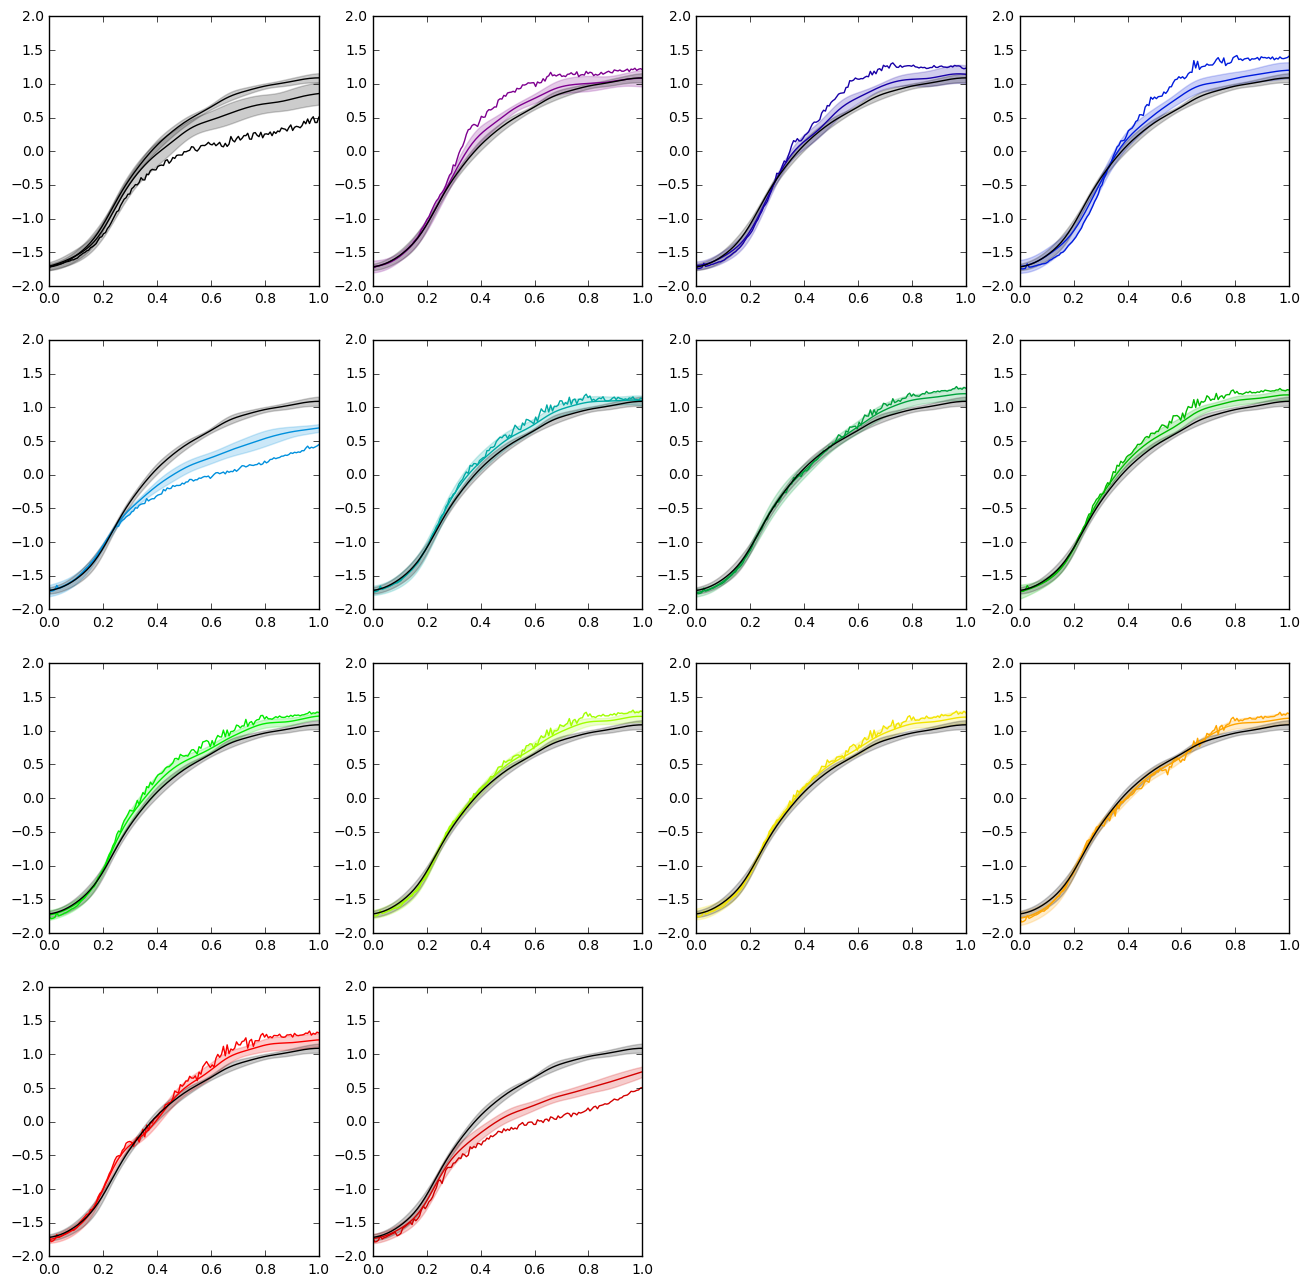

In [181]:
plt.figure(figsize=(16,16))

for e in range(neffect):
    plt.subplot(neffect/4+1,4,e+1)
    samp = m_randomEffect_bio_intRep.functionSamples(0).values + m_randomEffect_bio_intRep.functionSamples(e+1).values
    gpfanova.plot.plotFunctionSamples(samp,x=x[:,0],c=cmap(1.*e/neffect))
    plt.plot(x[:,0],y[:,effect.values[:,0]==e].mean(1),c=cmap(1.*e/neffect))
    
    gpfanova.plot.plotFunctionSamples(m_randomEffect_bio_intRep.functionSamples(0).values,x=x[:,0],c='k')
    
    plt.ylim(-2,2)

(-2, 1.5)

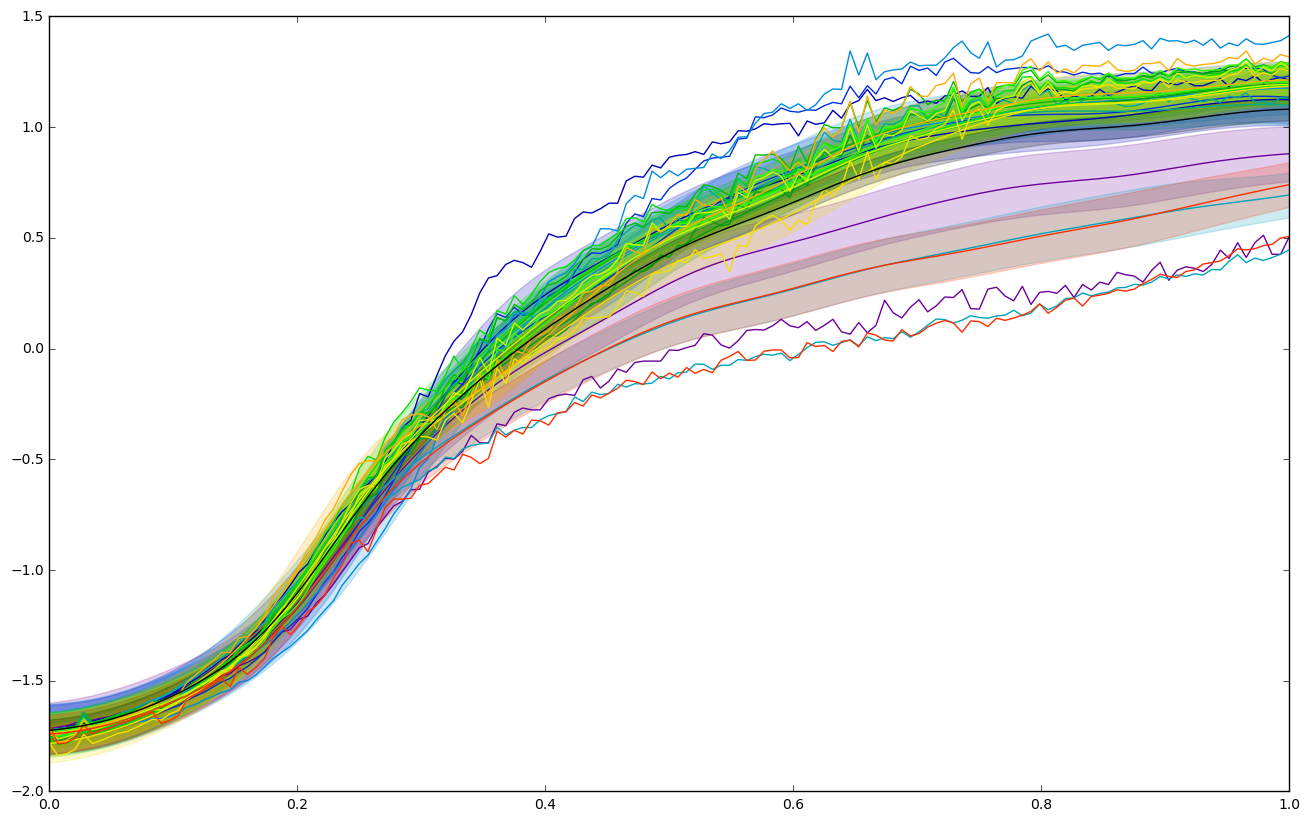

In [678]:
plt.figure(figsize=(16,10))

buff = 2
for e in range(neffect):
    samp = m_randomEffect_bio_intRep.functionSamples(0).values + m_randomEffect_bio_intRep.functionSamples(e+1).values
    gpfanova.plot.plotFunctionSamples(samp,x=x[:,0],c=cmap(1.*(e+buff)/(neffect+2*buff)))
    plt.plot(x[:,0],y[:,effect.values[:,0]==e].mean(1),c=cmap(1.*(e+buff)/(neffect+2*buff)))
    
gpfanova.plot.plotFunctionSamples(m_randomEffect_bio_intRep.functionSamples(0).values,x=x[:,0],c='k')
    
plt.ylim(-2,1.5)

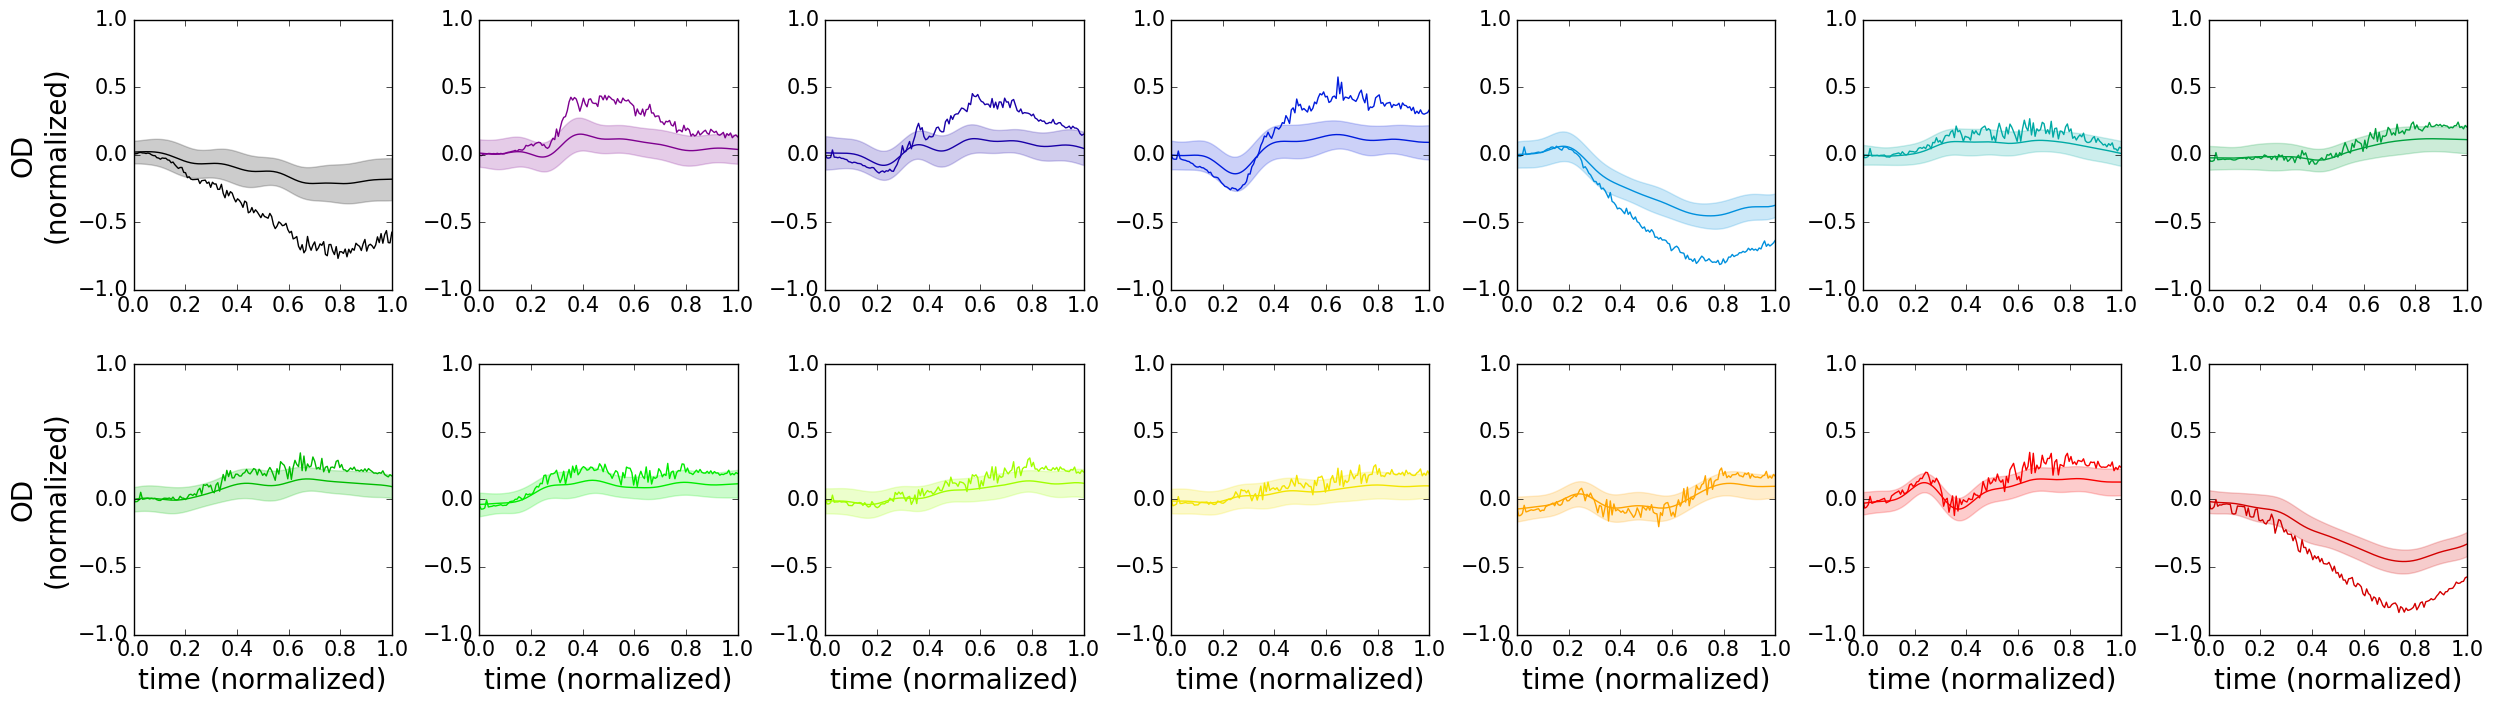

In [194]:
plt.figure(figsize=(25,10))

for e in range(neffect):
    plt.subplot(neffect/7+1,7,e+1)
    samp = m_randomEffect_bio_intRep.functionSamples(e+1).values
    gpfanova.plot.plotFunctionSamples(samp,x=x[:,0],c=cmap(1.*e/neffect))
    plt.plot(x[:,0],y[:,effect.values[:,0]==e].mean(1)-m_randomEffect_bio_intRep.functionSamples(0).values.mean(0),c=cmap(1.*e/neffect))
    
    if e >= 7:
        plt.xlabel("time (normalized)",fontsize=20)
        
    if e%7 == 0:
        plt.ylabel("OD\n(normalized)",fontsize=20)
        
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    
    plt.ylim(-1,1)
    
plt.tight_layout()
plt.savefig("figures/ura3-pq-replicate/model-multipleReplicates-bio.pdf",bbox_inches='tight',dpi=300)

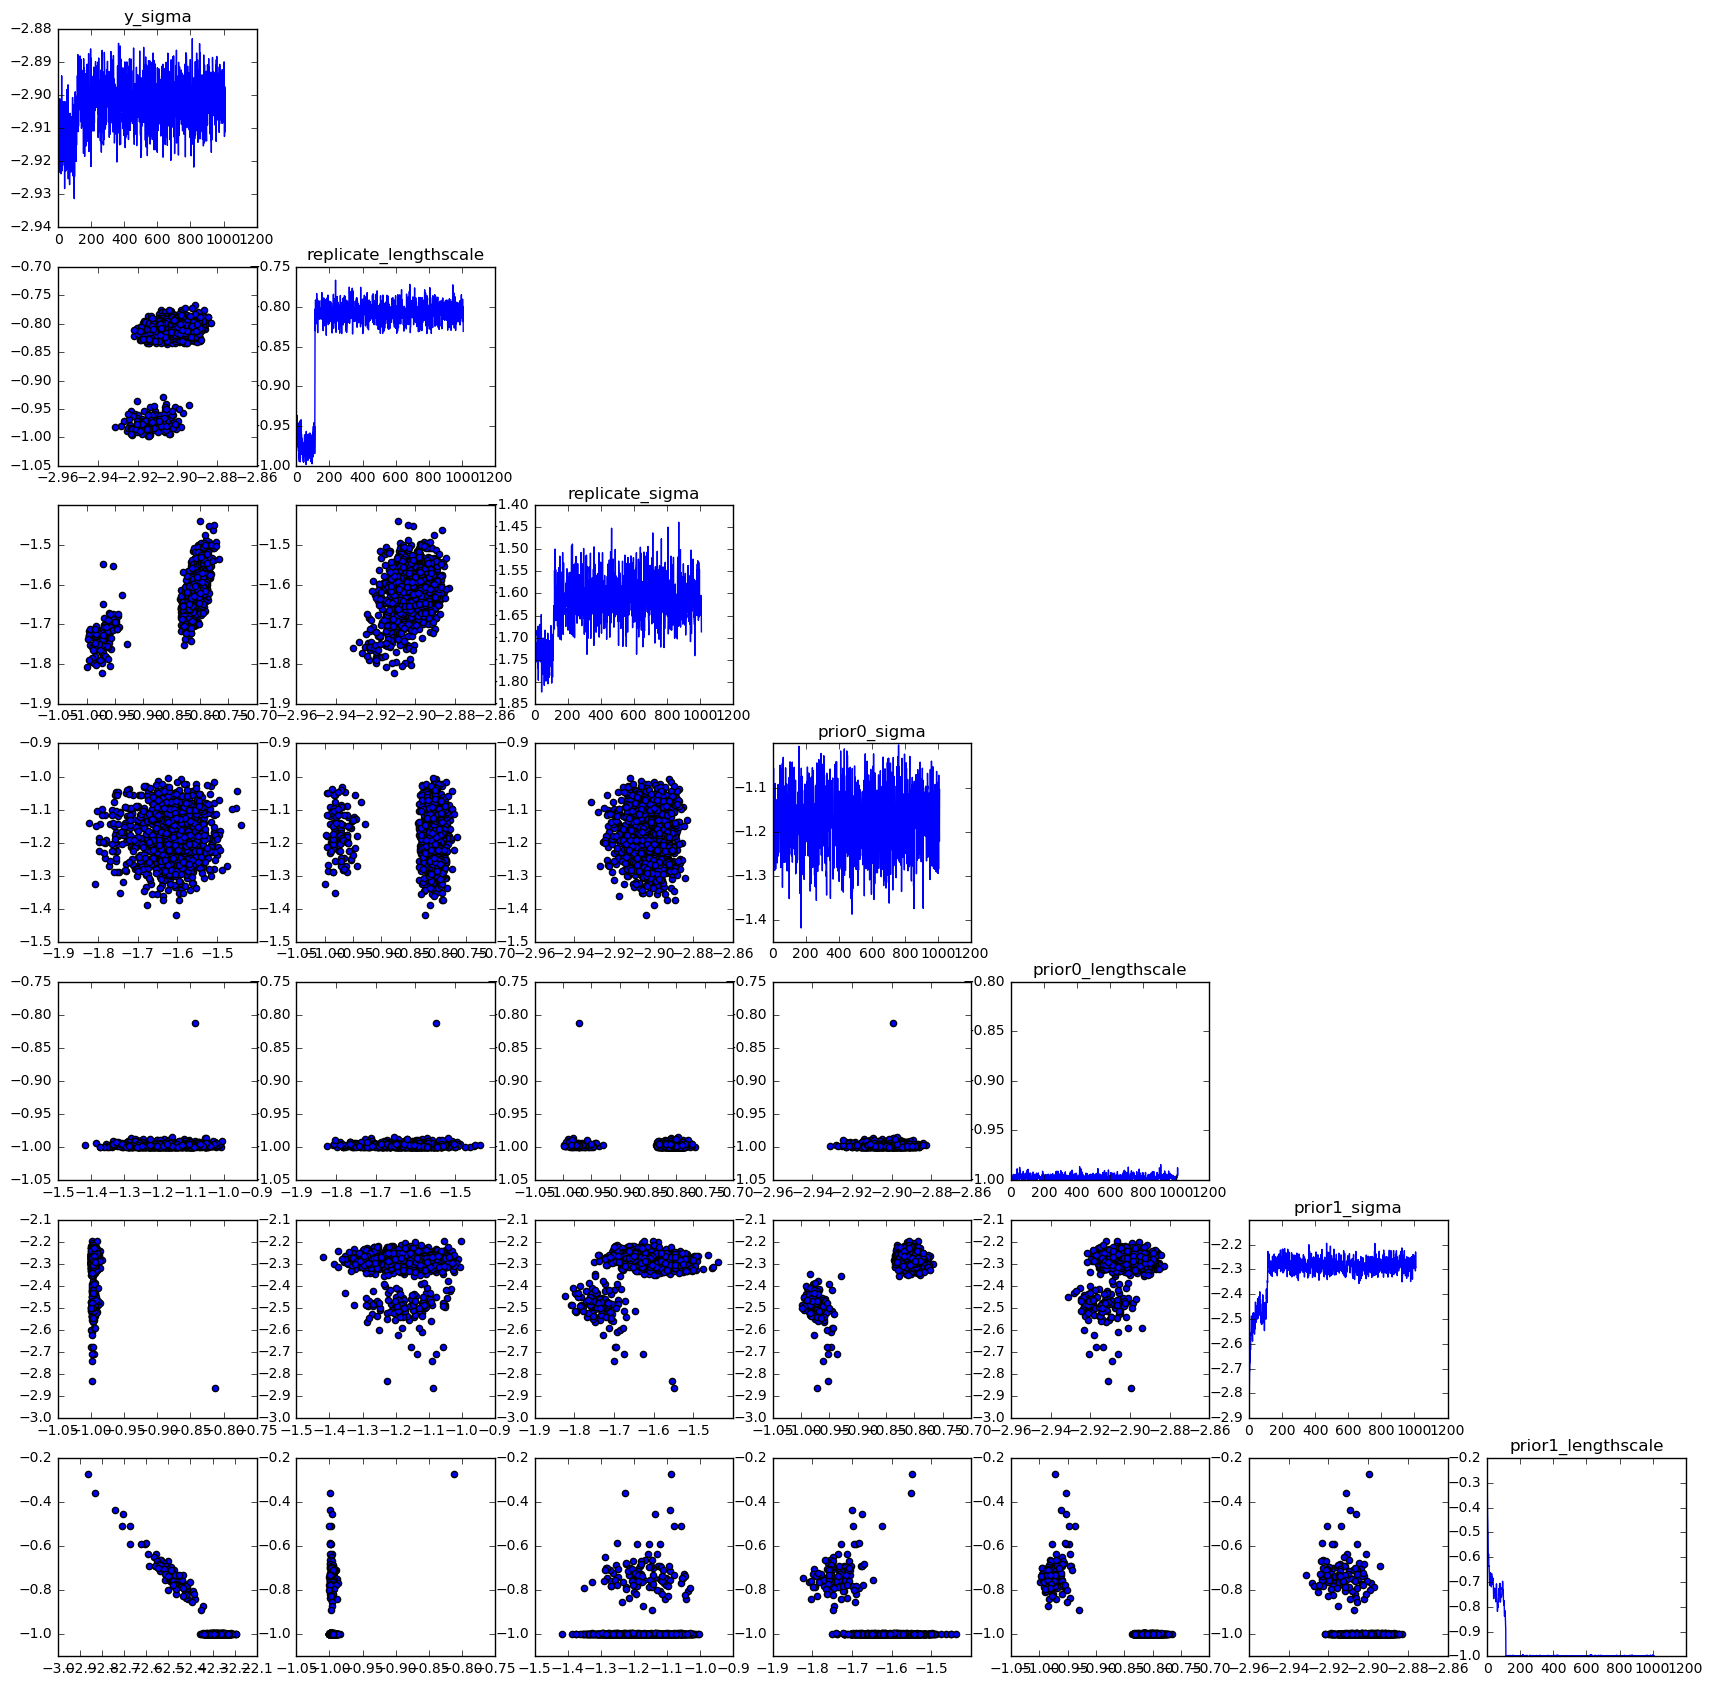

In [680]:
params = ['y_sigma','replicate_lengthscale','replicate_sigma','prior0_sigma','prior0_lengthscale','prior1_sigma','prior1_lengthscale']

plt.figure(figsize=(len(params)*3,len(params)*3))
for i,p in enumerate(params):
    plt.subplot(len(params),len(params),i+1+i*len(params))
    plt.title(p)
    plt.plot(m_randomEffect_bio_intRep.parameter_history[p])
    
    for j,p2 in enumerate(params[:i]):
        plt.subplot(len(params),len(params),i+1+i*len(params)-j-1)
        plt.scatter(m_randomEffect_bio_intRep.parameter_history[p2],m_randomEffect_bio_intRep.parameter_history[p])

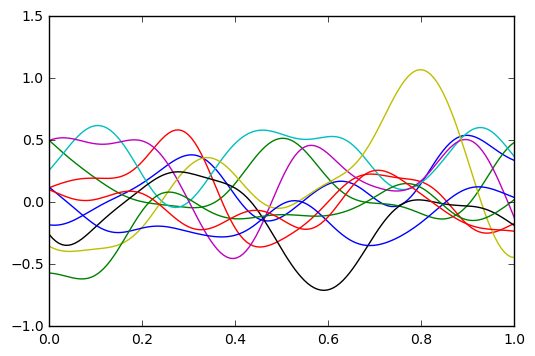

In [687]:
cov = m_randomEffect_bio_intRep.kernels[1].K(m_randomEffect.x,prior1_sigma=-1)

fsample = scipy.stats.multivariate_normal.rvs(np.zeros(x.shape[0]),cov,size=10)

plt.plot(x[:,0],fsample.T);

## Seperate prior for each BIO 

In [690]:
bounds = {'prior%d_sigma'%i:(-4,-1) for i in range(dm_randomEffect_intRep.shape[1])}
bounds.update({'prior%d_lengthscale'%i:(-1,2) for i in range(dm_randomEffect_intRep.shape[1])})
bounds['y_sigma'] = (-4,-1)

bounds

{'prior0_lengthscale': (-1, 2),
 'prior0_sigma': (-4, -1),
 'prior10_lengthscale': (-1, 2),
 'prior10_sigma': (-4, -1),
 'prior11_lengthscale': (-1, 2),
 'prior11_sigma': (-4, -1),
 'prior12_lengthscale': (-1, 2),
 'prior12_sigma': (-4, -1),
 'prior13_lengthscale': (-1, 2),
 'prior13_sigma': (-4, -1),
 'prior14_lengthscale': (-1, 2),
 'prior14_sigma': (-4, -1),
 'prior1_lengthscale': (-1, 2),
 'prior1_sigma': (-4, -1),
 'prior2_lengthscale': (-1, 2),
 'prior2_sigma': (-4, -1),
 'prior3_lengthscale': (-1, 2),
 'prior3_sigma': (-4, -1),
 'prior4_lengthscale': (-1, 2),
 'prior4_sigma': (-4, -1),
 'prior5_lengthscale': (-1, 2),
 'prior5_sigma': (-4, -1),
 'prior6_lengthscale': (-1, 2),
 'prior6_sigma': (-4, -1),
 'prior7_lengthscale': (-1, 2),
 'prior7_sigma': (-4, -1),
 'prior8_lengthscale': (-1, 2),
 'prior8_sigma': (-4, -1),
 'prior9_lengthscale': (-1, 2),
 'prior9_sigma': (-4, -1),
 'y_sigma': (-4, -1)}

In [691]:
# dm_randomEffect_intRep = np.column_stack((np.ones(y.shape[1]),
#                                    bioMatrix,))

m_randomEffect_bio_intRep_seperate = gpfanova.base.Base_withReplicate(x,y,designMatrix=dm_randomEffect_intRep,
                                        priorGroups=[[i] for i in range(dm_randomEffect_intRep.shape[1])],
                                        bounds=bounds,
                                        replicateSigmaBounds=(-4,-1),
                                        replicateLengthscaleBounds=(-1,2))

ERROR:gpfanova.base:design matrix is of rank 14, but there are 15 functions!


(-4, -1)


In [ ]:
m_randomEffect_bio_intRep_seperate.sample(300,thin=10)

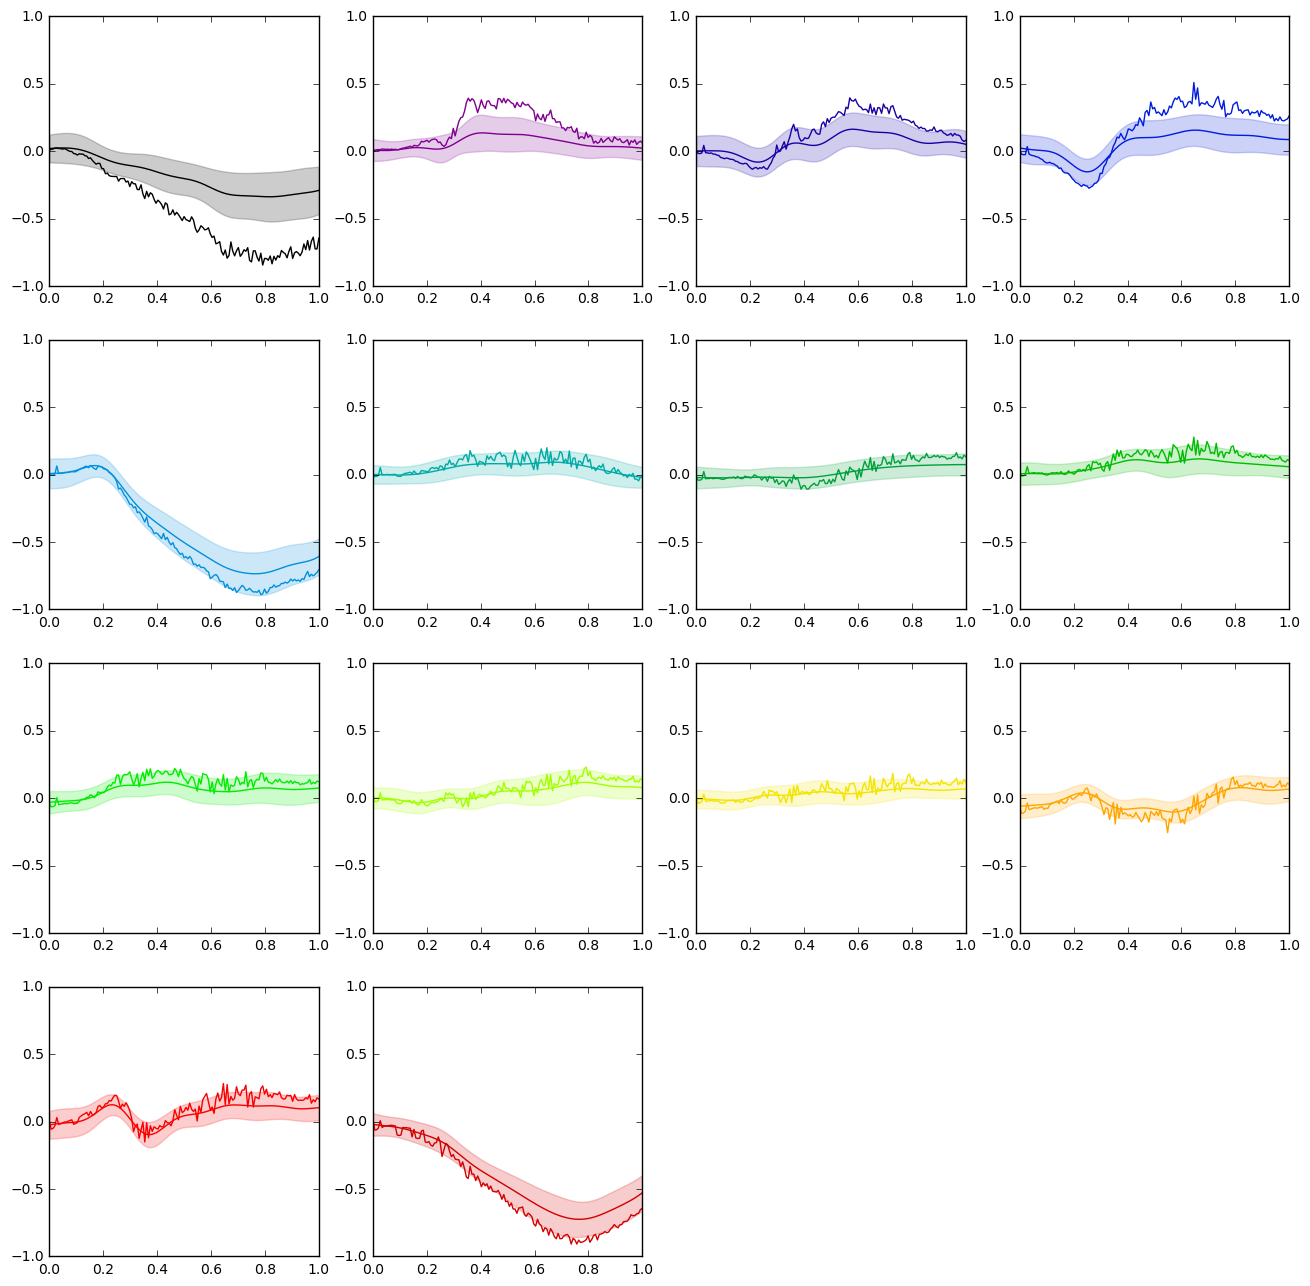

In [695]:
plt.figure(figsize=(16,16))

for e in range(neffect):
    plt.subplot(neffect/4+1,4,e+1)
    samp = m_randomEffect_bio_intRep_seperate.functionSamples(e+1).values
    gpfanova.plot.plotFunctionSamples(samp,x=x[:,0],c=cmap(1.*e/neffect))
    plt.plot(x[:,0],y[:,effect.values[:,0]==e].mean(1)-m_randomEffect_bio_intRep_seperate.functionSamples(0).values.mean(0),c=cmap(1.*e/neffect))
    
    plt.ylim(-1,1)

In [697]:
params = bounds.keys()
params.sort()

plt.figure(figsize=(len(params)*3,len(params)*3))
for i,p in enumerate(params):
    plt.subplot(len(params),len(params),i+1+i*len(params))
    plt.title(p)
    plt.plot(m_randomEffect_bio_intRep_seperate.parameter_history[p])
    
    for j,p2 in enumerate(params[:i]):
        plt.subplot(len(params),len(params),i+1+i*len(params)-j-1)
        plt.scatter(m_randomEffect_bio_intRep_seperate.parameter_history[p2],m_randomEffect_bio_intRep_seperate.parameter_history[p])

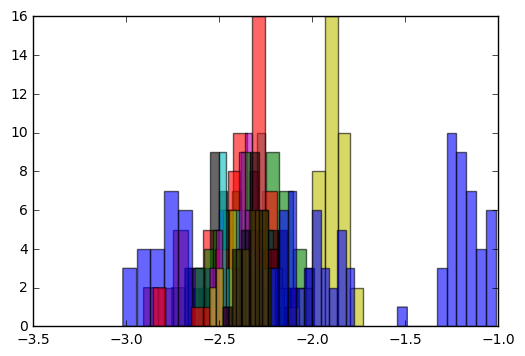

In [699]:
for i in range(dm_randomEffect_intRep.shape[1]):
    plt.hist(m_randomEffect_bio_intRep_seperate.parameter_history['prior%d_sigma'%i],alpha=.6)

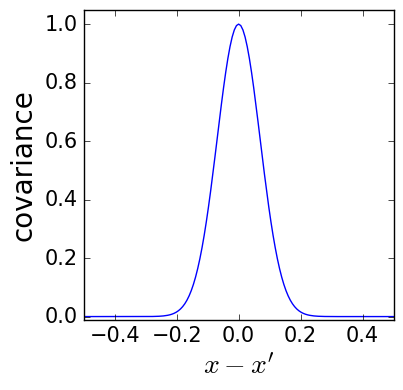

In [368]:
plt.figure(figsize=(4,4))

k = m_randomEffect.kernels[1].K(x)
plt.plot(x-x[x.shape[0]/2,0],k[x.shape[0]/2,:]/k.max())

plt.ylabel("covariance",fontsize=20)
plt.xlabel("$x-x'$",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.ylim(-.01,1.05)
plt.xlim(-.5,.5)

plt.savefig("figures/ura3-pq-replicate/example-kernel.png",bbox_inches='tight',dpi=300)

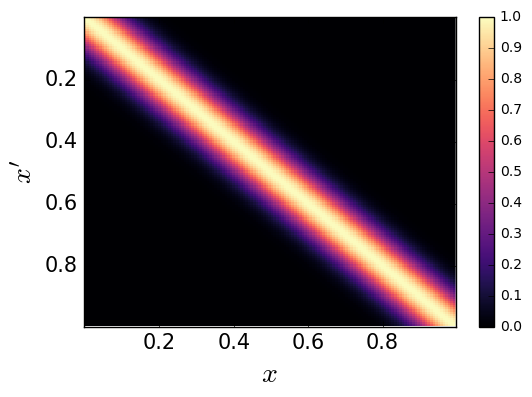

In [374]:
plt.figure(figsize=(6,4))

k = m_randomEffect.kernels[1].K(x)
plt.imshow(k/k.max(),cmap='magma',interpolation='none',aspect='auto')

# plt.ylabel("covariance",fontsize=20)
plt.xlabel("$x$",fontsize=20)
plt.ylabel("$x'$",fontsize=20)
plt.xticks(np.arange(x.shape[0]/5,x.shape[0],x.shape[0]/5),[z.round(1)[0] for z in x[x.shape[0]/5::x.shape[0]/5]],fontsize=15)
plt.yticks(np.arange(x.shape[0]/5,x.shape[0],x.shape[0]/5),[z.round(1)[0] for z in x[x.shape[0]/5::x.shape[0]/5]],fontsize=15)
# plt.yticks([])

# plt.ylim(-.01,1.05)
# plt.xlim(-.5,.5)

plt.colorbar()

plt.savefig("figures/ura3-pq-replicate/example-kernel-full.png",bbox_inches='tight',dpi=300)

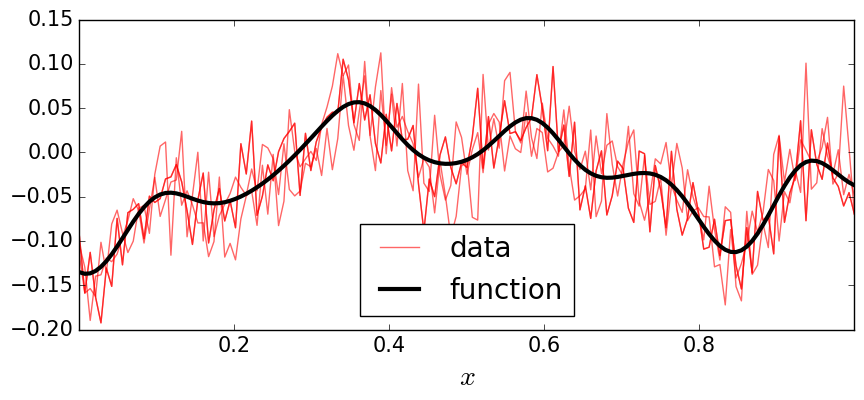

In [381]:
fsample = scipy.stats.multivariate_normal.rvs(np.zeros(x.shape[0]),k)
ysample = scipy.stats.multivariate_normal.rvs(fsample,m_randomEffect.y_k.K(x)*1.3,size=3)

plt.figure(figsize=(10,4))

plt.plot(x[:,0],ysample[0,:].T,'r',alpha=.6,label='data')
plt.plot(x[:,0],ysample.T,'r',alpha=.6)
plt.plot(x[:,0],fsample,'k',lw=3,label='function')

plt.xlabel("$x$",fontsize=20)
plt.xticks(np.arange(.2,1,.2),fontsize=15)
plt.yticks(fontsize=15)

plt.legend(loc='best',fontsize=20)

plt.savefig("figures/ura3-pq-replicate/example-data.png",bbox_inches='tight',dpi=300)

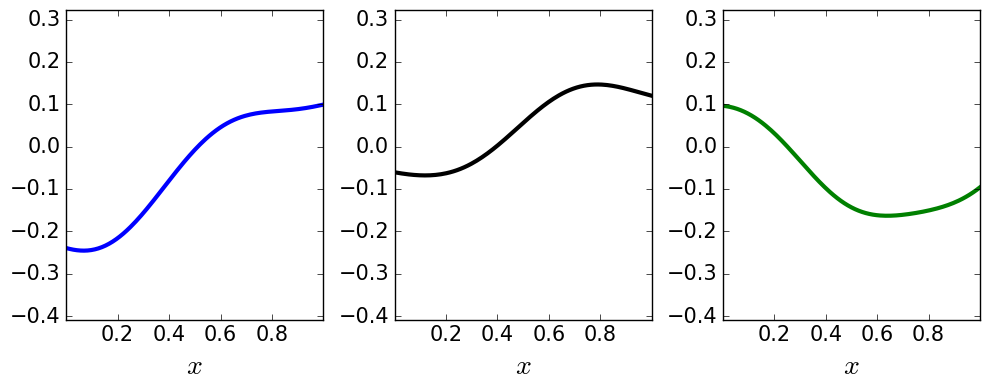

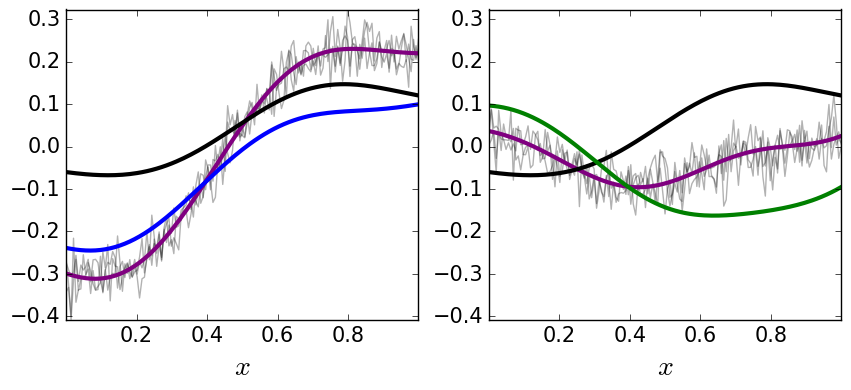

In [429]:
k = m_randomEffect.kernels[1].K(x,prior1_lengthscale=-.5)

fsample = scipy.stats.multivariate_normal.rvs(np.zeros(x.shape[0]),k,size=3)

dm = np.zeros((6,3))
dm[:,0] = 1
dm[:3,1] = 1
dm[3:,2] = 1

mu = np.dot(dm,fsample)
ysample = np.array([scipy.stats.multivariate_normal.rvs(mu[i,:],m_randomEffect.y_k.K(x)*1.3) for i in range(mu.shape[0])]).T

plt.figure(figsize=(10,4))

# plt.plot(x[:,0],fsample.T,'k',lw=3,label='function')

plt.subplot(132)
plt.plot(x[:,0],fsample[0,:],'k',lw=3,label='function')

plt.xlabel("$x$",fontsize=20)
plt.xticks(np.arange(.2,1,.2),fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(ysample.min(),ysample.max())

plt.subplot(131)
plt.plot(x[:,0],fsample[1,:],'b',lw=3,label='function')

plt.xlabel("$x$",fontsize=20)
plt.xticks(np.arange(.2,1,.2),fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(ysample.min(),ysample.max())

plt.subplot(133)
plt.plot(x[:,0],fsample[2,:],'g',lw=3,label='function')

plt.xlabel("$x$",fontsize=20)
plt.xticks(np.arange(.2,1,.2),fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(ysample.min(),ysample.max())

plt.tight_layout()

plt.savefig("figures/ura3-pq-replicate/example-multiple-functions.png",bbox_inches='tight',dpi=300)

plt.figure(figsize=(10,4))

plt.subplot(121)

plt.plot(x[:,0],ysample[:,:3],'k',alpha=.3)
plt.plot(x[:,0],fsample[:2,:].sum(0),'purple',alpha=1,lw=3)
plt.plot(x[:,0],fsample[0,:],'k',alpha=1,lw=3)
plt.plot(x[:,0],fsample[1,:],'b',alpha=1,lw=3)
plt.xlabel("$x$",fontsize=20)
plt.xticks(np.arange(.2,1,.2),fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(ysample.min(),ysample.max())

plt.subplot(122)

plt.plot(x[:,0],ysample[:,3:],'k',alpha=.3)
plt.plot(x[:,0],fsample[[0,2],:].sum(0),'purple',alpha=1,lw=3)
plt.plot(x[:,0],fsample[0,:],'k',alpha=1,lw=3)
plt.plot(x[:,0],fsample[2,:],'g',alpha=1,lw=3)

plt.xlabel("$x$",fontsize=20)
plt.xticks(np.arange(.2,1,.2),fontsize=15)
plt.yticks(fontsize=15)

plt.ylim(ysample.min(),ysample.max())


plt.savefig("figures/ura3-pq-replicate/example-multiple-data.png",bbox_inches='tight',dpi=300)

In [392]:
x.shape

(145, 1)